In [8]:
import pandas as pd  #pacotes
import numpy as np   #calculo numerico
import glob          #listas
#Codigo para declarar um pyarrow parquet - Willian - 29/05/2018
import pyarrow.parquet as pq
#uproot serve para ler a partir o python um arquivo em tree root
#import uproot
import os, sys
from os import path
import datetime
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
from matplotlib.colors import BoundaryNorm
%matplotlib inline

## A DIFERENÇA AQUI É DATASET DE 168h, POR 4 SEMANAS ON E OFF

In [9]:
%run def_functions.ipynb
%run def_functions_hits.ipynb
%run def_functions_fits.ipynb


In [10]:

# para 4 x 7 dias

list_ON1 = ['20200820','20200821','20200822','20200823','20200824','20200825','20200826']
list_ON2 = ['20200827','20200828','20200829','20200830','20200831','20200901','20200902']
list_ON3 = ['20200903','20200904','20200905','20200906','20200907','20200908','20200909']
list_ON4 = ['20200910','20200911','20200912','20200913','20200924','20200925','20200926']
#           '20200927','20200928'

list_OFF1 = ['20200624','20200625','20200626','20200627','20200628','20200629','20200630']
list_OFF2 = ['20200701','20200702','20200703','20200704','20200705','20200706','20200707']
list_OFF3 = ['20200708','20200709','20200710','20200711','20200712','20200713','20200714']
list_OFF4 = ['20200715','20200716','20200717','20200718','20200719','20200720','20200721']
#            '20200722','20200723'

list_ONO1 = ['20201001','20201002','20201003','20201004','20201005','20201006','20201007']
list_ONO2 = ['20201008','20201009','20201010','20201011','20201012','20201013','20201014']
list_ONO3 = ['20201015','20201016','20201017','20201018','20201019','20201020','20201021']
list_ONO4 = ['20201022','20201023','20201024','20201025','20201026','20201027','20201028']
#            '20201029','20201030'

list_ONN1 = ['20201101','20201102','20201103','20201104','20201105','20201106','20201107']
list_ONN2 = ['20201108','20201109','20201110','20201111','20201112','20201113','20201114','20201115','20201116','20201117']
list_ONN3 = ['20201118','20201119','20201120','20201121','20201122','20201123','20201124','20201125','20201126','20201127',
             '20201128','20201129','20201130','20201201','20201202']
list_ONN4 = ['20201203','20201204','20201205','20201206','20201207','20201208','20201209','20201210','20201211','20201212',
             '20201213','20201214','20201215','20201216','20201217','20201218']


In [11]:
#chi_sq_tab = 2.366  # chi quadrado tabelado para 3 graus de liberdades com 50%
#chi_sq_tab = 6.251  # chi quadrado tabelado para 3 graus de liberdades com 90%
chi_sq_tab = 7.815  # chi quadrado tabelado para 3 graus de liberdades com 95%
#chi_sq_tab = 10.597  # chi quadrado tabelado para 3 graus de liberdades com 995%
rh, rw = 150, 150
prompt_mean, prompt_var = 61.45215100965759, 1337.7332240825515
delay_mean, delay_var = 94.3970297029703, 4899.284941672385 
time_mean, time_var = 12.70, 12.70
itime_mean, itime_var = 1/12.70, 1/(12.70**2)

IBD_Esperado = 6610 #eventos por dia


## Função para processar lista

In [12]:
bins_interval = [63.134941, 66.91160302, 70.68826504, 74.46492707, 78.24158909,
 82.01825112, 85.79491314, 89.57157517, 93.34823719, 97.12489922,
 100.90156124, 104.67822326, 108.45488529, 112.23154731, 116.00820934, 
 119.78487136, 123.56153339, 127.33819541, 131.11485744, 134.89151946,
 138.66818149, 142.44484351, 146.22150553, 149.99816756, 153.77482958,
 157.55149161, 161.32815363, 165.10481566, 168.88147768, 172.65813971,
 176.43480173, 180.21146375, 183.98812578, 187.7647878, 191.54144983,
 195.31811185, 199.09477388, 202.8714359, 206.64809793, 210.42475995,
 214.20142197, 217.978084, 221.75474602, 225.53140805, 229.30807007,
 233.0847321, 236.86139412, 240.63805615, 244.41471817, 248.19138019]

#print(bins_interval)

def fnt_search_pos (f_pe):
    arr = [i for i, j in enumerate(bins_interval) if j >= f_pe]
    if len(arr)==0:
        res=-1
    else:
        res = arr[0]
    return res

#print(fnt_search_pos(67))  #2
#print(fnt_search_pos(55))   #0
#print(fnt_search_pos(100))  #10
#print(fnt_search_pos(300))  #-1

In [15]:
def fnt_process_list_PD (p_list, p_h_PDP, p_h_PDD, p_h_PDT, p_h_PD_pPDF, p_h_MUP, p_h_MUD, p_list_bins):
    i_day = 0
    p_totalPositrons = 0
    p_totalNonSat = 0
    p_count_bin = [ [] for y in range(len(p_list)) ]
    p_dp_bin = [ [] for y in range(len(p_list)) ]
    p_dpr_bin = [ [] for y in range(len(p_list)) ]                      

    print('sinal v2 - 8us < t < 50us')

    for sListDt in p_list:
        yyyy=int(sListDt[0:4]); mm=int(sListDt[4:6]); dd=int(sListDt[6:8])
    
        sDate = '{0:d}-{1:0>2d}-{2:0>2d}'.format(yyyy,mm,dd)
        sDir='data/{0:d}{1:0>2d}{2:0>2d}'.format(yyyy,mm,dd)
        print(sDir)
        lista = find_interval_date_pair(sDate,sDate,sDir)
        p_h_NonSat = []

        for file in lista:
            df = pd.read_parquet(file)
            dff = df[(df['p_satured']==0)&(df['d_satured']==0)
                            &(fnt_pe2MeV(df['p_Total_pe'])>=3)&(fnt_pe2MeV(df['p_Total_pe'])<=10)
                            &(fnt_pe2MeV(df['d_Total_pe'])>=1.6)&(fnt_pe2MeV(df['d_Total_pe'])<=7.12)
                            &(df['d_timeInverval']>=8)&(df['d_timeInverval']<=50)
                           # &(df['d_mPMTs']>=25)
                    ]
            p_h_PDP.extend(dff['p_Total_pe'].values)
            p_h_MUP.extend(dff['p_mPMTs'].values)
            p_h_PDD.extend(dff['d_Total_pe'].values)
            p_h_MUD.extend(dff['d_mPMTs'].values)
            p_h_PDT.extend(dff['d_timeInverval'].values)
            p_h_PD_pPDF.extend(dff['p_PDF'].values)

            dfns = df[(df['p_satured']==0)&(df['d_satured']==0)]

            p_totalPositrons += df.count()[0]
            p_totalNonSat += dfns.count()[0]

            p_h_NonSat.extend(dff['p_Total_pe'].values)            

            #print(p_totalPositrons)
            #break
                
        print('calculando bin')
                      
        p_bin_NonSat = [ [] for y in range(len(p_list_bins)) ]
                      
        ## 1- Navegar na lista de prompt dos eventos filtrados e separá-los em bins de pe
        for iw in range(len(p_h_NonSat)):
            i_b_pos = fnt_search_pos(p_h_NonSat[iw])
            if (i_b_pos!=-1):
                p_bin_NonSat[i_b_pos].append(p_h_NonSat[iw])
        
        ## 2- Navegar na lista de bins e contar quantos eventos ocorreram no dia
        for sb in range(len(p_list_bins)):
            p_count_bin[i_day].append(len(p_bin_NonSat[sb]))

        i_day += 1
        #break   ## Somente 1 dia de runs

    print('calculando sigmas')
    p_sigma_bin = []
    for sbr in range(len(p_list_bins)):
        cday_NSat = []
        for dd in range(i_day):
            cday_NSat.append(p_count_bin[dd][sbr])
         
        p_sigma_bin.append(np.sum(cday_NSat))  # contagem de eventos/dia

    return p_totalPositrons, p_totalNonSat, p_sigma_bin #, p_sigmar_bin, p_std_bin


## Salvar e carregar Listas ON / OFF

In [14]:
##save values - h_Sig_OFF2 (contém o sigma de cada bin dividido por 5dias)
def save_PD (dh_PDP, dh_MUP, dh_PDD, dh_MUD, dh_PDT, dh_Sig, sName):
    # dictionary of lists
    dict = {'dh_PDP': dh_PDP,
            'dh_MUP': dh_MUP,
            'dh_PDD': dh_PDD,
            'dh_MUD': dh_MUD,
            'dh_PDT': dh_PDT}
    
    dict2 = {'dh_Sig': dh_Sig}
 
    # creating a dataframe from dictionary
    dfw = pd.DataFrame(dict)
    dfw.to_parquet('data/Analise_ONOFF/'+sName+'.parq', compression='gzip')

    dfw2 = pd.DataFrame(dict2)
    dfw2.to_parquet('data/Analise_ONOFF/Sig_'+sName+'.parq', compression='gzip')

    del dict2
    del dict
    
##load values
def load_PD (sName): #(dh_PDP, dh_PDD, dh_PDT, dh_Sig, sName):
    dfr = pd.read_parquet('data/Analise_ONOFF/'+sName+'.parq')
    dfr2 = pd.read_parquet('data/Analise_ONOFF/Sig_'+sName+'.parq')
    return(dfr['dh_PDP'].values, dfr['dh_MUP'].values, dfr['dh_PDD'].values, dfr['dh_MUD'].values, dfr['dh_PDT'].values, dfr2['dh_Sig'].values)

    

## Processamento para OFF1

In [28]:
print('Inicio',datetime.datetime.now())
h_PDP_OFF1 = []
h_MUP_OFF1 = []
h_PDD_OFF1 = []
h_MUD_OFF1 = []
h_PDT_OFF1 = []
h_PD_pPDF_OFF1 = []
totalPositrons_OFF1 = 0
totalNonSat_OFF1 = 0
h_Sig_OFF1 = []

totalPositrons_OFF1, totalNonSat_OFF1, h_Sig_OFF1 = fnt_process_list_PD(list_OFF1, h_PDP_OFF1, h_PDD_OFF1, h_PDT_OFF1, h_PD_pPDF_OFF1, h_MUP_OFF1, h_MUD_OFF1, bins_interval)
                            
print(len(h_PDP_OFF1))
print(len(h_PDD_OFF1))
print(len(h_PDT_OFF1))
print('Em ',len(list_OFF1),' dias: ',totalPositrons_OFF1)
print('Por dia: ',totalPositrons_OFF1/len(list_OFF1))
print('Em Hz: ',totalPositrons_OFF1/len(list_OFF1)/86400) 
print('Em ',len(list_OFF1),' dias (NS): ',totalNonSat_OFF1)
print('Por dia (NS): ',totalNonSat_OFF1/len(list_OFF1))
print('Em Hz (NS): ',totalNonSat_OFF1/len(list_OFF1)/86400) 


i_day = len(list_OFF1)

#print(h_Sig_OFF1)
print(np.sum(h_Sig_OFF1))
print([(x*i_day) for x in h_Sig_OFF1])
print(np.sum([(x*i_day) for x in h_Sig_OFF1]))

hg_Sig_OFF1 = [((x*i_day)**0.5) for x in h_Sig_OFF1]
#print(hg_Sig_OFF1)

print('Fim',datetime.datetime.now())

Inicio 2024-04-21 22:57:35.456498
sinal v2 - 8us < t < 50us
data/20200624
calculando bin
data/20200625
calculando bin
data/20200626
calculando bin
data/20200627
calculando bin
data/20200628
calculando bin
data/20200629
calculando bin
data/20200630
calculando bin
calculando sigmas
311194
311194
311194
Em  7  dias:  115607584
Por dia:  16515369.142857144
Em Hz:  191.15010582010584
Em  7  dias (NS):  74297093
Por dia (NS):  10613870.42857143
Em Hz (NS):  122.84572255291006
311160
[784, 224476, 207277, 191296, 175952, 157101, 139993, 126287, 110432, 95900, 84378, 72520, 63007, 55055, 46760, 42924, 37506, 33943, 30198, 27090, 23870, 22785, 19551, 18417, 16982, 14364, 13713, 12271, 11228, 10500, 9303, 8498, 7763, 7007, 6727, 5803, 5271, 5264, 4361, 4375, 3948, 3661, 3143, 2982, 2716, 2646, 2254, 2149, 1974, 1715]
2178120
Fim 2024-04-21 23:29:13.744325


## Processamento para OFF2

In [29]:
print('Inicio',datetime.datetime.now())

h_PDP_OFF2 = []
h_MUP_OFF2 = []
h_PDD_OFF2 = []
h_MUD_OFF2 = []
h_PDT_OFF2 = []
h_PD_pPDF_OFF2 = []
totalPositrons_OFF2 = 0
totalNonSat_OFF2 = 0
h_Sig_OFF2 = []

totalPositrons_OFF2, totalNonSat_OFF2, h_Sig_OFF2 = fnt_process_list_PD(list_OFF2, h_PDP_OFF2, h_PDD_OFF2, h_PDT_OFF2, h_PD_pPDF_OFF2, h_MUP_OFF2, h_MUD_OFF2, bins_interval)
                            
print(len(h_PDP_OFF2))
print(len(h_PDD_OFF2))
print(len(h_PDT_OFF2))
print('Em ',len(list_OFF2),' dias: ',totalPositrons_OFF2)
print('Por dia: ',totalPositrons_OFF2/len(list_OFF2))
print('Em Hz: ',totalPositrons_OFF2/len(list_OFF2)/86400) 
print('Em ',len(list_OFF2),' dias (NS): ',totalNonSat_OFF2)
print('Por dia (NS): ',totalNonSat_OFF2/len(list_OFF2))
print('Em Hz (NS): ',totalNonSat_OFF2/len(list_OFF2)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_OFF2))

hg_Sig_OFF2 = [(x**0.5) for x in h_Sig_OFF2]
print('\nRoot of Sig: ', hg_Sig_OFF2)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-21 23:29:13.948150
sinal v2 - 8us < t < 50us
data/20200701
calculando bin
data/20200702
calculando bin
data/20200703
calculando bin
data/20200704
calculando bin
data/20200705
calculando bin
data/20200706
calculando bin
data/20200707
calculando bin
calculando sigmas
311585
311585
311585
Em  7  dias:  115424936
Por dia:  16489276.57142857
Em Hz:  190.84810846560845
Em  7  dias (NS):  74100780
Por dia (NS):  10585825.714285715
Em Hz (NS):  122.52113095238096

Sum of Sig:  311548

Root of Sig:  [11.090536506409418, 178.68128049686683, 172.47898422706461, 165.53851515583918, 158.4897473024675, 149.78651474682226, 141.7885749981288, 133.48408144793896, 125.7179382586272, 117.08970919769166, 109.48515881159419, 101.46427942877237, 95.28903399657277, 88.43076387773658, 83.09031231136396, 77.71100308193171, 72.69112738154499, 69.83552104767315, 65.06919393998976, 62.64982043070834, 58.71115737234278, 55.839054433254866, 53.47896782848375, 51.44900387762624, 49.02040391510457, 46.

## Processamento para OFF3

In [30]:
print('Inicio',datetime.datetime.now())

h_PDP_OFF3 = []
h_MUP_OFF3 = []
h_PDD_OFF3 = []
h_MUD_OFF3 = []
h_PDT_OFF3 = []
h_PD_pPDF_OFF3 = []
totalPositrons_OFF3 = 0
totalNonSat_OFF3 = 0
h_Sig_OFF3 = []

totalPositrons_OFF3, totalNonSat_OFF3, h_Sig_OFF3 = fnt_process_list_PD(list_OFF3, h_PDP_OFF3, h_PDD_OFF3, h_PDT_OFF3, h_PD_pPDF_OFF3, h_MUP_OFF3, h_MUD_OFF3, bins_interval)
                            
print(len(h_PDP_OFF3))
print(len(h_PDD_OFF3))
print(len(h_PDT_OFF3))
print('Em ',len(list_OFF3),' dias: ',totalPositrons_OFF3)
print('Por dia: ',totalPositrons_OFF3/len(list_OFF3))
print('Em Hz: ',totalPositrons_OFF3/len(list_OFF3)/86400) 
print('Em ',len(list_OFF3),' dias (NS): ',totalNonSat_OFF3)
print('Por dia (NS): ',totalNonSat_OFF3/len(list_OFF3))
print('Em Hz (NS): ',totalNonSat_OFF3/len(list_OFF3)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_OFF3))

hg_Sig_OFF3 = [(x**0.5) for x in h_Sig_OFF3]
print('\nRoot of Sig: ', hg_Sig_OFF3)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-22 00:02:08.127967
sinal v2 - 8us < t < 50us
data/20200708
calculando bin
data/20200709
calculando bin
data/20200710
calculando bin
data/20200711
calculando bin
data/20200712
calculando bin
data/20200713
calculando bin
data/20200714
calculando bin
calculando sigmas
314533
314533
314533
Em  7  dias:  116168503
Por dia:  16595500.42857143
Em Hz:  192.07755125661376
Em  7  dias (NS):  75112924
Por dia (NS):  10730417.714285715
Em Hz (NS):  124.19464947089948

Sum of Sig:  314493

Root of Sig:  [11.489125293076057, 180.61284561182242, 173.8936456573385, 166.7872896835967, 158.117045254457, 151.4199458459816, 142.87407042567241, 133.64131097830492, 125.61050911448453, 118.19898476721363, 109.37549999885715, 101.4051280754578, 95.66608594481119, 88.87631855561975, 82.98192574289898, 77.61443164772902, 73.64781055808787, 69.29646455628166, 66.01514977639603, 62.41794613730894, 59.95831885568507, 56.089214649520635, 54.58021619598075, 51.526692111953004, 48.78524367060187, 46.90

## Processamento para OFF4

In [31]:
print('Inicio',datetime.datetime.now())

h_PDP_OFF4 = []
h_MUP_OFF4 = []
h_PDD_OFF4 = []
h_MUD_OFF4 = []
h_PDT_OFF4 = []
h_PD_pPDF_OFF4 = []
totalPositrons_OFF4 = 0
totalNonSat_OFF4 = 0
h_Sig_OFF4 = []

totalPositrons_OFF4, totalNonSat_OFF4, h_Sig_OFF4 = fnt_process_list_PD(list_OFF4, h_PDP_OFF4, h_PDD_OFF4, h_PDT_OFF4, h_PD_pPDF_OFF4, h_MUP_OFF4, h_MUD_OFF4, bins_interval)
                            
print(len(h_PDP_OFF4))
print(len(h_PDD_OFF4))
print(len(h_PDT_OFF4))
print('Em ',len(list_OFF4),' dias: ',totalPositrons_OFF4)
print('Por dia: ',totalPositrons_OFF4/len(list_OFF4))
print('Em Hz: ',totalPositrons_OFF4/len(list_OFF4)/86400) 
print('Em ',len(list_OFF4),' dias (NS): ',totalNonSat_OFF4)
print('Por dia (NS): ',totalNonSat_OFF4/len(list_OFF4))
print('Em Hz (NS): ',totalNonSat_OFF4/len(list_OFF4)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_OFF4))

hg_Sig_OFF4 = [(x**0.5) for x in h_Sig_OFF4]
print('\nRoot of Sig: ', hg_Sig_OFF4)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-22 00:34:32.705467
sinal v2 - 8us < t < 50us
data/20200715
calculando bin
data/20200716
calculando bin
data/20200717
calculando bin
data/20200718
calculando bin
data/20200719
calculando bin
data/20200720
calculando bin
data/20200721
calculando bin
calculando sigmas
299816
299816
299816
Em  7  dias:  113410396
Por dia:  16201485.142857144
Em Hz:  187.51718915343918
Em  7  dias (NS):  73181946
Por dia (NS):  10454563.714285715
Em Hz (NS):  121.00189484126984

Sum of Sig:  299766

Root of Sig:  [10.770329614269007, 175.16563589928248, 169.85287751463028, 164.14932226482082, 155.61490931141526, 147.305804366291, 138.6650640933036, 131.36590120727678, 122.44182292011173, 114.15778554264269, 106.98598038995577, 99.4786409235671, 93.48796714016194, 87.12060605849801, 80.88881257627658, 76.12489737267302, 71.87489130426563, 68.25686778632608, 63.96092557178953, 60.663003552412405, 57.844619455918284, 54.56189146281496, 52.86775955154521, 49.42671342502959, 47.286361670147556, 45

## Processamento ON1

In [20]:
print('Inicio',datetime.datetime.now())

h_PDP_ON1 = []
h_MUP_ON1 = []
h_PDD_ON1 = []
h_MUD_ON1 = []
h_PDT_ON1 = []
h_PD_pPDF_ON1 = []
totalPositrons_ON1 = 0
totalNonSat_ON1 = 0
h_Sig_ON1 = []

totalPositrons_ON1, totalNonSat_ON1, h_Sig_ON1 = fnt_process_list_PD(list_ON1, h_PDP_ON1, h_PDD_ON1, h_PDT_ON1, h_PD_pPDF_ON1, h_MUP_ON1, h_MUD_ON1, bins_interval)
                            
print(len(h_PDP_ON1))
print(len(h_PDD_ON1))
print(len(h_PDT_ON1))
print('Em ',len(list_ON1),' dias: ',totalPositrons_ON1)
print('Por dia: ',totalPositrons_ON1/len(list_ON1))
print('Em Hz: ',totalPositrons_ON1/len(list_ON1)/86400) 
print('Em ',len(list_ON1),' dias (NS): ',totalNonSat_ON1)
print('Por dia (NS): ',totalNonSat_ON1/len(list_ON1))
print('Em Hz (NS): ',totalNonSat_ON1/len(list_ON1)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_ON1))

hg_Sig_ON1 = [(x**0.5) for x in h_Sig_ON1]
print('\nRoot of Sig: ', hg_Sig_ON1)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-21 18:50:16.013647
sinal v2 - 8us < t < 50us
data/20200820
calculando bin
data/20200821
calculando bin
data/20200822
calculando bin
data/20200823
calculando bin
data/20200824
calculando bin
data/20200825
calculando bin
data/20200826
calculando bin
calculando sigmas
298746
298746
298746
Em  7  dias:  112540040
Por dia:  16077148.57142857
Em Hz:  186.07810846560847
Em  7  dias (NS):  73383569
Por dia (NS):  10483367.0
Em Hz (NS):  121.33526620370371

Sum of Sig:  298706

Root of Sig:  [10.198039027185569, 175.43944824354642, 170.384858482202, 163.5665002376709, 154.7966407904254, 147.35331689514152, 138.77319625922004, 131.14495796636635, 122.60913505934214, 114.07453703609758, 105.83005244258362, 100.23971268913334, 93.16651759081692, 86.78133439859057, 80.93824806604107, 75.99342076785332, 71.72865536171719, 66.4981202741852, 63.198101237299845, 60.29925372672534, 57.175169435691224, 54.644304369257, 52.640288753007425, 49.8998997994986, 47.50789408087881, 44.85532298401

## Processamento ON2

In [21]:
print('Inicio',datetime.datetime.now())

h_PDP_ON2 = []
h_MUP_ON2 = []
h_PDD_ON2 = []
h_MUD_ON2 = []
h_PDT_ON2 = []
h_PD_pPDF_ON2 = []
totalPositrons_ON2 = 0
totalNonSat_ON2 = 0
h_Sig_ON2 = []

totalPositrons_ON2, totalNonSat_ON2, h_Sig_ON2 = fnt_process_list_PD(list_ON2, h_PDP_ON2, h_PDD_ON2, h_PDT_ON2, h_PD_pPDF_ON2, h_MUP_ON2, h_MUD_ON2, bins_interval)
                            
print(len(h_PDP_ON2))
print(len(h_PDD_ON2))
print(len(h_PDT_ON2))
print('Em ',len(list_ON2),' dias: ',totalPositrons_ON2)
print('Por dia: ',totalPositrons_ON2/len(list_ON2))
print('Em Hz: ',totalPositrons_ON2/len(list_ON2)/86400) 
print('Em ',len(list_ON2),' dias (NS): ',totalNonSat_ON2)
print('Por dia (NS): ',totalNonSat_ON2/len(list_ON2))
print('Em Hz (NS): ',totalNonSat_ON2/len(list_ON2)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_ON2))

hg_Sig_ON2 = [(x**0.5) for x in h_Sig_ON2]
print('\nRoot of Sig: ', hg_Sig_ON2)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-21 19:20:50.395760
sinal v2 - 8us < t < 50us
data/20200827
calculando bin
data/20200828
calculando bin
data/20200829
calculando bin
data/20200830
calculando bin
data/20200831
calculando bin
data/20200901
calculando bin
data/20200902
calculando bin
calculando sigmas
308408
308408
308408
Em  7  dias:  112998782
Por dia:  16142683.142857144
Em Hz:  186.83661044973545
Em  7  dias (NS):  74587641
Por dia (NS):  10655377.285714285
Em Hz (NS):  123.3261259920635

Sum of Sig:  308373

Root of Sig:  [10.246950765959598, 177.2484132510077, 172.6267650163207, 165.36626016210198, 157.67371372552878, 149.71305888265059, 141.07799261401476, 133.6487934850143, 124.54316520789088, 117.72000679578642, 109.2291169972549, 100.5087060905671, 95.23129737644027, 87.52713864853574, 82.68010643437755, 77.1621668954417, 72.11102550927978, 68.46166810705097, 64.10928169929842, 60.54750201288241, 58.240879114244144, 54.71745608121781, 52.392747589718944, 50.428166732491874, 48.60041152089147, 46.0

## Processamento ON3

In [22]:
print('Inicio',datetime.datetime.now())

h_PDP_ON3 = []
h_MUP_ON3 = []
h_PDD_ON3 = []
h_MUD_ON3 = []
h_PDT_ON3 = []
h_PD_pPDF_ON3 = []
totalPositrons_ON3 = 0
totalNonSat_ON3 = 0
h_Sig_ON3 = []

totalPositrons_ON3, totalNonSat_ON3, h_Sig_ON3 = fnt_process_list_PD(list_ON3, h_PDP_ON3, h_PDD_ON3, h_PDT_ON3, h_PD_pPDF_ON3, h_MUP_ON3, h_MUD_ON3, bins_interval)
                            
print(len(h_PDP_ON3))
print(len(h_PDD_ON3))
print(len(h_PDT_ON3))
print('Em ',len(list_ON3),' dias: ',totalPositrons_ON3)
print('Por dia: ',totalPositrons_ON3/len(list_ON3))
print('Em Hz: ',totalPositrons_ON3/len(list_ON3)/86400) 
print('Em ',len(list_ON3),' dias (NS): ',totalNonSat_ON3)
print('Por dia (NS): ',totalNonSat_ON3/len(list_ON3))
print('Em Hz (NS): ',totalNonSat_ON3/len(list_ON3)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_ON3))

hg_Sig_ON3 = [(x**0.5) for x in h_Sig_ON3]
print('\nRoot of Sig: ', hg_Sig_ON3)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-21 19:51:44.006149
sinal v2 - 8us < t < 50us
data/20200903
calculando bin
data/20200904
calculando bin
data/20200905
calculando bin
data/20200906
calculando bin
data/20200907
calculando bin
data/20200908
calculando bin
data/20200909
calculando bin
calculando sigmas
316722
316722
316722
Em  7  dias:  114681391
Por dia:  16383055.857142856
Em Hz:  189.61870205026455
Em  7  dias (NS):  76568015
Por dia (NS):  10938287.857142856
Em Hz (NS):  126.60055390211639

Sum of Sig:  316674

Root of Sig:  [9.899494936611665, 180.5076175677913, 174.6882938264611, 167.75279431353744, 159.93123522314207, 152.6695778470616, 144.2601816164114, 135.74240310234677, 125.85706178041819, 118.4483009586883, 109.89540481748998, 102.2985825903761, 94.70480452437458, 88.67355862939075, 83.55237878121723, 77.05841939723393, 73.35529974037323, 68.17624219623724, 64.31174076325411, 61.99193495931547, 57.93099343184095, 56.142675390472796, 53.1883445878888, 51.09794516416487, 47.93745925682754, 46.9574

## Processamento ON4

In [23]:
print('Inicio',datetime.datetime.now())

h_PDP_ON4 = []
h_MUP_ON4 = []
h_PDD_ON4 = []
h_MUD_ON4 = []
h_PDT_ON4 = []
h_PD_pPDF_ON4 = []
totalPositrons_ON4 = 0
totalNonSat_ON4 = 0
h_Sig_ON4 = []

totalPositrons_ON4, totalNonSat_ON4, h_Sig_ON4 = fnt_process_list_PD(list_ON4, h_PDP_ON4, h_PDD_ON4, h_PDT_ON4, h_PD_pPDF_ON4, h_MUP_ON4, h_MUD_ON4, bins_interval)
                            
print(len(h_PDP_ON4))
print(len(h_PDD_ON4))
print(len(h_PDT_ON4))
print('Em ',len(list_ON4),' dias: ',totalPositrons_ON4)
print('Por dia: ',totalPositrons_ON4/len(list_ON4))
print('Em Hz: ',totalPositrons_ON4/len(list_ON4)/86400) 
print('Em ',len(list_ON4),' dias (NS): ',totalNonSat_ON4)
print('Por dia (NS): ',totalNonSat_ON4/len(list_ON4))
print('Em Hz (NS): ',totalNonSat_ON4/len(list_ON4)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_ON4))

hg_Sig_ON4 = [(x**0.5) for x in h_Sig_ON4]
print('\nRoot of Sig: ', hg_Sig_ON4)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-21 20:23:31.078720
sinal v2 - 8us < t < 50us
data/20200910
calculando bin
data/20200911
calculando bin
data/20200912
calculando bin
data/20200913
calculando bin
data/20200924
calculando bin
data/20200925
calculando bin
data/20200926
calculando bin
calculando sigmas
314409
314409
314409
Em  7  dias:  113884362
Por dia:  16269194.57142857
Em Hz:  188.3008630952381
Em  7  dias (NS):  75985014
Por dia (NS):  10855002.0
Em Hz (NS):  125.63659722222222

Sum of Sig:  314375

Root of Sig:  [10.295630140987, 180.55470085267788, 174.0976737351766, 167.0628624201082, 159.3549497191725, 152.1512405470294, 143.94443372357264, 134.13426109685773, 126.20221868097248, 118.86547017532047, 109.64944140304591, 102.1665307231287, 94.41398201537736, 87.80091115700337, 81.92679659305617, 76.66159403508382, 72.22880311897741, 68.26419266350405, 64.8382603097893, 61.506097258727124, 58.38664230798, 55.41660400998964, 52.392747589718944, 51.30302135352264, 48.49742261192856, 46.49731175025068, 4

## Processamento para ONO1 (OUT/2020)

In [24]:
print('Inicio',datetime.datetime.now())

h_PDP_ONO1 = []
h_MUP_ONO1 = []
h_PDD_ONO1 = []
h_MUD_ONO1 = []
h_PDT_ONO1 = []
h_PD_pPDF_ONO1 = []
totalPositrons_ONO1 = 0
totalNonSat_ONO1 = 0
h_Sig_ONO1 = []

totalPositrons_ONO1, totalNonSat_ONO1, h_Sig_ONO1 = fnt_process_list_PD(list_ONO1, h_PDP_ONO1, h_PDD_ONO1, h_PDT_ONO1, h_PD_pPDF_ONO1, h_MUP_ONO1, h_MUD_ONO1, bins_interval)
                            
print(len(h_PDP_ONO1))
print(len(h_PDD_ONO1))
print(len(h_PDT_ONO1))
print('Em ',len(list_ONO1),' dias: ',totalPositrons_ONO1)
print('Por dia: ',totalPositrons_ONO1/len(list_ONO1))
print('Em Hz: ',totalPositrons_ONO1/len(list_ONO1)/86400) 
print('Em ',len(list_ONO1),' dias (NS): ',totalNonSat_ONO1)
print('Por dia (NS): ',totalNonSat_ONO1/len(list_ONO1))
print('Em Hz (NS): ',totalNonSat_ONO1/len(list_ONO1)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_ONO1))

hg_Sig_ONO1 = [(x**0.5) for x in h_Sig_ONO1]
print('\nRoot of Sig: ', hg_Sig_ONO1)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-21 20:55:12.632677
sinal v2 - 8us < t < 50us
data/20201001
calculando bin
data/20201002
calculando bin
data/20201003
calculando bin
data/20201004
calculando bin
data/20201005
calculando bin
data/20201006
calculando bin
data/20201007
calculando bin
calculando sigmas
316389
316389
316389
Em  7  dias:  112949679
Por dia:  16135668.42857143
Em Hz:  186.75542162698414
Em  7  dias (NS):  74139821
Por dia (NS):  10591403.0
Em Hz (NS):  122.58568287037038

Sum of Sig:  316346

Root of Sig:  [10.677078252031311, 180.63499107315835, 175.2797763576848, 168.056538105484, 160.84153692376856, 151.69377047196105, 142.84957122791795, 135.26270735128733, 125.60254774486066, 117.74548823628021, 110.09087155618307, 101.03464752252071, 95.03157370053387, 87.82368700982668, 82.58329128825031, 77.57576941287789, 72.50517222929686, 68.66585760041157, 64.79197481170026, 63.37191807101944, 59.20304046246274, 56.32938842203065, 53.2634959423431, 50.547007824400445, 48.91829923454004, 46.754678910

## Processamento para ONO2

In [25]:
print('Inicio',datetime.datetime.now())

h_PDP_ONO2 = []
h_MUP_ONO2 = []
h_PDD_ONO2 = []
h_MUD_ONO2 = []
h_PDT_ONO2 = []
h_PD_pPDF_ONO2 = []
totalPositrons_ONO2 = 0
totalNonSat_ONO2 = 0
h_Sig_ONO2 = []

totalPositrons_ONO2, totalNonSat_ONO2, h_Sig_ONO2 = fnt_process_list_PD(list_ONO2, h_PDP_ONO2, h_PDD_ONO2, h_PDT_ONO2, h_PD_pPDF_ONO2, h_MUP_ONO2, h_MUD_ONO2, bins_interval)
                            
print(len(h_PDP_ONO2))
print(len(h_PDD_ONO2))
print(len(h_PDT_ONO2))
print('Em ',len(list_ONO2),' dias: ',totalPositrons_ONO2)
print('Por dia: ',totalPositrons_ONO2/len(list_ONO2))
print('Em Hz: ',totalPositrons_ONO2/len(list_ONO2)/86400) 
print('Em ',len(list_ONO2),' dias (NS): ',totalNonSat_ONO2)
print('Por dia (NS): ',totalNonSat_ONO2/len(list_ONO2))
print('Em Hz (NS): ',totalNonSat_ONO2/len(list_ONO2)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_ONO2))

hg_Sig_ONO2 = [(x**0.5) for x in h_Sig_ONO2]
print('\nRoot of Sig: ', hg_Sig_ONO2)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-21 21:26:27.724467
sinal v2 - 8us < t < 50us
data/20201008
calculando bin
data/20201009
calculando bin
data/20201010
calculando bin
data/20201011
calculando bin
data/20201012
calculando bin
data/20201013
calculando bin
data/20201014
calculando bin
calculando sigmas
313191
313191
313191
Em  7  dias:  112132783
Por dia:  16018969.0
Em Hz:  185.40473379629628
Em  7  dias (NS):  74406247
Por dia (NS):  10629463.857142856
Em Hz (NS):  123.02620205026454

Sum of Sig:  313148

Root of Sig:  [10.954451150103322, 180.066654325558, 173.72679701186, 166.9221375372362, 159.18856742869445, 151.4199458459816, 142.57980221616245, 134.43957750603056, 125.42328332490742, 117.13667231059623, 109.4120651482276, 100.87120500916008, 94.27088627991147, 88.15327560561774, 82.85529554590944, 76.8830280361017, 72.46378405796926, 68.53466276272175, 64.8613906727261, 62.457985878508765, 58.38664230798, 55.98214000911362, 52.687759489277965, 50.774009099144415, 48.25971404805462, 46.71188285650665,

## Processamento para ONO3

In [26]:
print('Inicio',datetime.datetime.now())

h_PDP_ONO3 = []
h_MUP_ONO3 = []
h_PDD_ONO3 = []
h_MUD_ONO3 = []
h_PDT_ONO3 = []
h_PD_pPDF_ONO3 = []
totalPositrons_ONO3 = 0
totalNonSat_ONO3 = 0
h_Sig_ONO3 = []

totalPositrons_ONO3, totalNonSat_ONO3, h_Sig_ONO3 = fnt_process_list_PD(list_ONO3, h_PDP_ONO3, h_PDD_ONO3, h_PDT_ONO3, h_PD_pPDF_ONO3, h_MUP_ONO3, h_MUD_ONO3, bins_interval)
                            
print(len(h_PDP_ONO3))
print(len(h_PDD_ONO3))
print(len(h_PDT_ONO3))
print('Em ',len(list_ONO3),' dias: ',totalPositrons_ONO3)
print('Por dia: ',totalPositrons_ONO3/len(list_ONO3))
print('Em Hz: ',totalPositrons_ONO3/len(list_ONO3)/86400) 
print('Em ',len(list_ONO3),' dias (NS): ',totalNonSat_ONO3)
print('Por dia (NS): ',totalNonSat_ONO3/len(list_ONO3))
print('Em Hz (NS): ',totalNonSat_ONO3/len(list_ONO3)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_ONO3))

hg_Sig_ONO3 = [(x**0.5) for x in h_Sig_ONO3]
print('\nRoot of Sig: ', hg_Sig_ONO3)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-21 21:57:28.137089
sinal v2 - 8us < t < 50us
data/20201015
calculando bin
data/20201016
calculando bin
data/20201017
calculando bin
data/20201018
calculando bin
data/20201019
calculando bin
data/20201020
calculando bin
data/20201021
calculando bin
calculando sigmas
299850
299850
299850
Em  7  dias:  108619399
Por dia:  15517057.0
Em Hz:  179.59556712962964
Em  7  dias (NS):  72560688
Por dia (NS):  10365812.57142857
Em Hz (NS):  119.97468253968253

Sum of Sig:  299807

Root of Sig:  [10.488088481701515, 175.3596304740632, 169.6850022836432, 163.77728780267427, 156.2241978696002, 148.00675660252813, 140.0856880626997, 132.4764129949177, 122.71104269787622, 113.72774507568502, 107.35455276791944, 98.95453501482385, 93.1611507013519, 86.60254037844386, 80.06247560499239, 74.19568720619817, 71.88880302244571, 66.76825593049439, 62.56996084384263, 59.79130371550699, 57.82732917920384, 53.88877434122992, 52.10566188045211, 49.193495504995376, 47.148700936505136, 45.60701700396

## Processamento para ON4

In [27]:
print('Inicio',datetime.datetime.now())

h_PDP_ONO4 = []
h_MUP_ONO4 = []
h_PDD_ONO4 = []
h_MUD_ONO4 = []
h_PDT_ONO4 = []
h_PD_pPDF_ONO4 = []
totalPositrons_ONO4 = 0
totalNonSat_ONO4 = 0
h_Sig_ONO4 = []

totalPositrons_ONO4, totalNonSat_ONO4, h_Sig_ONO4 = fnt_process_list_PD(list_ONO4, h_PDP_ONO4, h_PDD_ONO4, h_PDT_ONO4, h_PD_pPDF_ONO4, h_MUP_ONO4, h_MUD_ONO4, bins_interval)
                            
print(len(h_PDP_ONO4))
print(len(h_PDD_ONO4))
print(len(h_PDT_ONO4))
print('Em ',len(list_ONO4),' dias: ',totalPositrons_ONO4)
print('Por dia: ',totalPositrons_ONO4/len(list_ONO4))
print('Em Hz: ',totalPositrons_ONO4/len(list_ONO4)/86400) 
print('Em ',len(list_ONO4),' dias (NS): ',totalNonSat_ONO4)
print('Por dia (NS): ',totalNonSat_ONO4/len(list_ONO4))
print('Em Hz (NS): ',totalNonSat_ONO4/len(list_ONO4)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_ONO4))

hg_Sig_ONO4 = [(x**0.5) for x in h_Sig_ONO4]
print('\nRoot of Sig: ', hg_Sig_ONO4)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-21 22:27:33.372539
sinal v2 - 8us < t < 50us
data/20201022
calculando bin
data/20201023
calculando bin
data/20201024
calculando bin
data/20201025
calculando bin
data/20201026
calculando bin
data/20201027
calculando bin
data/20201028
calculando bin
calculando sigmas
303642
303642
303642
Em  7  dias:  107580104
Por dia:  15368586.285714285
Em Hz:  177.8771560846561
Em  7  dias (NS):  70517166
Por dia (NS):  10073880.857142856
Em Hz (NS):  116.59584325396824

Sum of Sig:  303606

Root of Sig:  [9.797958971132712, 177.06778363101515, 172.19756095833645, 164.28329190760695, 155.3319027115808, 149.6629546681476, 140.64494303031304, 132.18169313486644, 124.1772926102031, 115.03912377969506, 107.62434668791258, 99.49371839468057, 93.9095309327014, 86.75828490697589, 80.89499366462674, 76.83749084919418, 72.44308110509934, 66.9776081985614, 62.960304954788775, 60.23288138550239, 57.41950887982237, 55.560777532356404, 52.44044240850758, 49.63869458396343, 47.8748368143433, 45.8257

## Processamento para ONN1 (nov/2020 - 7d)

In [16]:
print('Inicio',datetime.datetime.now())

h_PDP_ONN1 = []
h_MUP_ONN1 = []
h_PDD_ONN1 = []
h_MUD_ONN1 = []
h_PDT_ONN1 = []
h_PD_pPDF_ONN1 = []
totalPositrons_ONN1 = 0
totalNonSat_ONN1 = 0
h_Sig_ONN1 = []

totalPositrons_ONN1, totalNonSat_ONN1, h_Sig_ONN1 = fnt_process_list_PD(list_ONN1, h_PDP_ONN1, h_PDD_ONN1, h_PDT_ONN1, h_PD_pPDF_ONN1, h_MUP_ONN1, h_MUD_ONN1, bins_interval)
                            
print(len(h_PDP_ONN1))
print(len(h_PDD_ONN1))
print(len(h_PDT_ONN1))
print('Em ',len(list_ONN1),' dias: ',totalPositrons_ONN1)
print('Por dia: ',totalPositrons_ONN1/len(list_ONN1))
print('Em Hz: ',totalPositrons_ONN1/len(list_ONN1)/86400) 
print('Em ',len(list_ONN1),' dias (NS): ',totalNonSat_ONN1)
print('Por dia (NS): ',totalNonSat_ONN1/len(list_ONN1))
print('Em Hz (NS): ',totalNonSat_ONN1/len(list_ONN1)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_ONN1))

hg_Sig_ONN1 = [(x**0.5) for x in h_Sig_ONN1]
print('\nRoot of Sig: ', hg_Sig_ONN1)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-21 16:51:01.859299
sinal v2 - 8us < t < 50us
data/20201101
calculando bin
data/20201102
calculando bin
data/20201103
calculando bin
data/20201104
calculando bin
data/20201105
calculando bin
data/20201106
calculando bin
data/20201107
calculando bin
calculando sigmas
293396
293396
293396
Em  7  dias:  106055629
Por dia:  15150804.142857144
Em Hz:  175.35652943121693
Em  7  dias (NS):  69956225
Por dia (NS):  9993746.42857143
Em Hz (NS):  115.66836144179895

Sum of Sig:  293353

Root of Sig:  [10.04987562112089, 175.13994404475525, 169.0325412457613, 161.20173696334663, 154.81601984290901, 147.305804366291, 138.75518008348374, 130.24592124131948, 122.23338332877806, 113.7848847606746, 104.50358845513392, 97.96938297243685, 91.63514609580758, 84.4630096551147, 79.68061244744545, 74.75961476626267, 70.17121917139534, 65.16901104052447, 62.02418882984283, 59.38013135721409, 56.74504383644443, 53.47896782848375, 51.39066063011839, 49.16299421312742, 46.389654018972806, 44.24929

## Processamento para ONN2

In [17]:
print('Inicio',datetime.datetime.now())

h_PDP_ONN2 = []
h_MUP_ONN2 = []
h_PDD_ONN2 = []
h_MUD_ONN2 = []
h_PDT_ONN2 = []
h_PD_pPDF_ONN2 = []
totalPositrons_ONN2 = 0
totalNonSat_ONN2 = 0
h_Sig_ONN2 = []

totalPositrons_ONN2, totalNonSat_ONN2, h_Sig_ONN2 = fnt_process_list_PD(list_ONN2, h_PDP_ONN2, h_PDD_ONN2, h_PDT_ONN2, h_PD_pPDF_ONN2, h_MUP_ONN2, h_MUD_ONN2, bins_interval)
                            
print(len(h_PDP_ONN2))
print(len(h_PDD_ONN2))
print(len(h_PDT_ONN2))
print('Em ',len(list_ONN2),' dias: ',totalPositrons_ONN2)
print('Por dia: ',totalPositrons_ONN2/len(list_ONN2))
print('Em Hz: ',totalPositrons_ONN2/len(list_ONN2)/86400) 
print('Em ',len(list_ONN2),' dias (NS): ',totalNonSat_ONN2)
print('Por dia (NS): ',totalNonSat_ONN2/len(list_ONN2))
print('Em Hz (NS): ',totalNonSat_ONN2/len(list_ONN2)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_ONN2))

hg_Sig_ONN2 = [(x**0.5) for x in h_Sig_ONN2]
print('\nRoot of Sig: ', hg_Sig_ONN2)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-21 17:20:42.294686
sinal v2 - 8us < t < 50us
data/20201108
calculando bin
data/20201109
calculando bin
data/20201110
calculando bin
data/20201111
calculando bin
data/20201112
calculando bin
data/20201113
calculando bin
data/20201114
calculando bin
data/20201115
calculando bin
data/20201116
calculando bin
data/20201117
calculando bin
calculando sigmas
301400
301400
301400
Em  10  dias:  109587043
Por dia:  10958704.3
Em Hz:  126.83685532407408
Em  10  dias (NS):  71326720
Por dia (NS):  7132672.0
Em Hz (NS):  82.55407407407408

Sum of Sig:  301364

Root of Sig:  [10.488088481701515, 177.2484132510077, 171.84004189943624, 165.13933510826547, 155.93267778115015, 148.94629904767692, 139.8070098385628, 131.2211873136347, 123.20308437697491, 115.3819743287486, 106.42368157510809, 98.84836872705588, 93.34345183246653, 86.0, 81.22807396460905, 75.63729238940273, 70.77428911688199, 67.19374970932937, 62.984124983998946, 59.15234568468101, 57.38466694161429, 53.44155686354955, 51.

## Processamento para ONN3

In [18]:
print('Inicio',datetime.datetime.now())

h_PDP_ONN3 = []
h_MUP_ONN3 = []
h_PDD_ONN3 = []
h_MUD_ONN3 = []
h_PDT_ONN3 = []
h_PD_pPDF_ONN3 = []
totalPositrons_ONN3 = 0
totalNonSat_ONN3 = 0
h_Sig_ONN3 = []

totalPositrons_ONN3, totalNonSat_ONN3, h_Sig_ONN3 = fnt_process_list_PD(list_ONN3, h_PDP_ONN3, h_PDD_ONN3, h_PDT_ONN3, h_PD_pPDF_ONN3, h_MUP_ONN3, h_MUD_ONN3, bins_interval)
                            
print(len(h_PDP_ONN3))
print(len(h_PDD_ONN3))
print(len(h_PDT_ONN3))
print('Em ',len(list_ONN3),' dias: ',totalPositrons_ONN3)
print('Por dia: ',totalPositrons_ONN3/len(list_ONN3))
print('Em Hz: ',totalPositrons_ONN3/len(list_ONN3)/86400) 
print('Em ',len(list_ONN3),' dias (NS): ',totalNonSat_ONN3)
print('Por dia (NS): ',totalNonSat_ONN3/len(list_ONN3))
print('Em Hz (NS): ',totalNonSat_ONN3/len(list_ONN3)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_ONN3))

hg_Sig_ONN3 = [(x**0.5) for x in h_Sig_ONN3]
print('\nRoot of Sig: ', hg_Sig_ONN3)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-21 17:50:55.180427
sinal v2 - 8us < t < 50us
data/20201118
calculando bin
data/20201119
calculando bin
data/20201120
calculando bin
data/20201121
calculando bin
data/20201122
calculando bin
data/20201123
calculando bin
data/20201124
calculando bin
data/20201125
calculando bin
data/20201126
calculando bin
data/20201127
calculando bin
data/20201128
calculando bin
data/20201129
calculando bin
data/20201130
calculando bin
data/20201201
calculando bin
data/20201202
calculando bin
calculando sigmas
295880
295880
295880
Em  15  dias:  107416496
Por dia:  7161099.733333333
Em Hz:  82.8830987654321
Em  15  dias (NS):  70055413
Por dia (NS):  4670360.866666666
Em Hz (NS):  54.05510262345678

Sum of Sig:  295845

Root of Sig:  [10.04987562112089, 175.8323064740948, 169.71446608937023, 162.47153596861205, 155.23530526268823, 147.41099009232656, 139.19410907075056, 130.93891705677117, 121.4207560510146, 114.57748469922004, 106.17438485811914, 98.52918349402881, 91.8313671900838, 85.2

## Processamento para ONN4

In [19]:
print('Inicio',datetime.datetime.now())

h_PDP_ONN4 = []
h_MUP_ONN4 = []
h_PDD_ONN4 = []
h_MUD_ONN4 = []
h_PDT_ONN4 = []
h_PD_pPDF_ONN4 = []
totalPositrons_ONN4 = 0
totalNonSat_ONN4 = 0
h_Sig_ONN4 = []

totalPositrons_ONN4, totalNonSat_ONN4, h_Sig_ONN4 = fnt_process_list_PD(list_ONN4, h_PDP_ONN4, h_PDD_ONN4, h_PDT_ONN4, h_PD_pPDF_ONN4, h_MUP_ONN4, h_MUD_ONN4, bins_interval)
                            
print(len(h_PDP_ONN4))
print(len(h_PDD_ONN4))
print(len(h_PDT_ONN4))
print('Em ',len(list_ONN4),' dias: ',totalPositrons_ONN4)
print('Por dia: ',totalPositrons_ONN4/len(list_ONN4))
print('Em Hz: ',totalPositrons_ONN4/len(list_ONN4)/86400) 
print('Em ',len(list_ONN4),' dias (NS): ',totalNonSat_ONN4)
print('Por dia (NS): ',totalNonSat_ONN4/len(list_ONN4))
print('Em Hz (NS): ',totalNonSat_ONN4/len(list_ONN4)/86400) 

print('\nSum of Sig: ', np.sum(h_Sig_ONN4))

hg_Sig_ONN4 = [(x**0.5) for x in h_Sig_ONN4]
print('\nRoot of Sig: ', hg_Sig_ONN4)

        
print('Fim',datetime.datetime.now())

Inicio 2024-04-21 18:20:45.054510
sinal v2 - 8us < t < 50us
data/20201203
calculando bin
data/20201204
calculando bin
data/20201205
calculando bin
data/20201206
calculando bin
data/20201207
calculando bin
data/20201208
calculando bin
data/20201209
calculando bin
data/20201210
calculando bin
data/20201211
calculando bin
data/20201212
calculando bin
data/20201213
calculando bin
data/20201214
calculando bin
data/20201215
calculando bin
data/20201216
calculando bin
data/20201217
calculando bin
data/20201218
calculando bin
calculando sigmas
291393
291393
291393
Em  16  dias:  107069963
Por dia:  6691872.6875
Em Hz:  77.45223017939814
Em  16  dias (NS):  68436199
Por dia (NS):  4277262.4375
Em Hz (NS):  49.50535228587963

Sum of Sig:  291348

Root of Sig:  [10.246950765959598, 175.32541173486518, 168.28844285927659, 161.81470884935027, 153.46009253222806, 147.02380759591284, 137.1203850636367, 129.64181424216494, 120.77665337307538, 113.19010557464817, 104.65180361560904, 97.62684057163789, 

## Salvar todas as listas processadas para excessos

In [33]:
save_PD (h_PDP_OFF1, h_MUP_OFF1, h_PDD_OFF1, h_MUD_OFF1, h_PDT_OFF1, hg_Sig_OFF1, 'PD_OFF1_168h_v2')
save_PD (h_PDP_OFF2, h_MUP_OFF2, h_PDD_OFF2, h_MUD_OFF2, h_PDT_OFF2, hg_Sig_OFF2, 'PD_OFF2_168h_v2')
save_PD (h_PDP_OFF3, h_MUP_OFF3, h_PDD_OFF3, h_MUD_OFF3, h_PDT_OFF3, hg_Sig_OFF3, 'PD_OFF3_168h_v2')
save_PD (h_PDP_OFF4, h_MUP_OFF4, h_PDD_OFF4, h_MUD_OFF4, h_PDT_OFF4, hg_Sig_OFF4, 'PD_OFF4_168h_v2')

save_PD (h_PDP_ON1, h_MUP_ON1, h_PDD_ON1, h_MUD_ON1, h_PDT_ON1, hg_Sig_ON1, 'PD_ON1_168h_v2')
save_PD (h_PDP_ON2, h_MUP_ON2, h_PDD_ON2, h_MUD_ON2, h_PDT_ON2, hg_Sig_ON2, 'PD_ON2_168h_v2')
save_PD (h_PDP_ON3, h_MUP_ON3, h_PDD_ON3, h_MUD_ON3, h_PDT_ON3, hg_Sig_ON3, 'PD_ON3_168h_v2')
save_PD (h_PDP_ON4, h_MUP_ON4, h_PDD_ON4, h_MUD_ON4, h_PDT_ON4, hg_Sig_ON4, 'PD_ON4_168h_v2')

save_PD (h_PDP_ONO1, h_MUP_ONO1, h_PDD_ONO1, h_MUD_ONO1, h_PDT_ONO1, hg_Sig_ONO1, 'PD_ONO1_168h_v2')
save_PD (h_PDP_ONO2, h_MUP_ONO2, h_PDD_ONO2, h_MUD_ONO2, h_PDT_ONO2, hg_Sig_ONO2, 'PD_ONO2_168h_v2')
save_PD (h_PDP_ONO3, h_MUP_ONO3, h_PDD_ONO3, h_MUD_ONO3, h_PDT_ONO3, hg_Sig_ONO3, 'PD_ONO3_168h_v2')
save_PD (h_PDP_ONO4, h_MUP_ONO4, h_PDD_ONO4, h_MUD_ONO4, h_PDT_ONO4, hg_Sig_ONO4, 'PD_ONO4_168h_v2')

save_PD (h_PDP_ONN1, h_MUP_ONN1, h_PDD_ONN1, h_MUD_ONN1, h_PDT_ONN1, hg_Sig_ONN1, 'PD_ONN1_168h_v2')
save_PD (h_PDP_ONN2, h_MUP_ONN2, h_PDD_ONN2, h_MUD_ONN2, h_PDT_ONN2, hg_Sig_ONN2, 'PD_ONN2_168h_v2')
save_PD (h_PDP_ONN3, h_MUP_ONN3, h_PDD_ONN3, h_MUD_ONN3, h_PDT_ONN3, hg_Sig_ONN3, 'PD_ONN3_168h_v2')
save_PD (h_PDP_ONN4, h_MUP_ONN4, h_PDD_ONN4, h_MUD_ONN4, h_PDT_ONN4, hg_Sig_ONN4, 'PD_ONN4_168h_v2')


## Resultado Final

## Plot genérico por atribuição

In [38]:

gnh_PDP_ON = h_PDP_ONO1
gnh_Sig_ON = hg_Sig_ONO1 

ls_dataI = list_ONO1[0]
ls_dataF = list_ONO1[len(list_ONO1)-1]

tl_set1 = 'ON ('+ls_dataI[6:8]+'/'+ls_dataI[4:6]+'/'+ls_dataI[0:4]+' a '+ls_dataF[6:8]+'/'+ls_dataF[4:6]+'/'+ls_dataF[0:4]+')'
print(tl_set1)

gnh_PDP_OFF = h_PDP_OFF1
gnh_Sig_OFF = hg_Sig_OFF1 

ls_dataI = list_OFF1[0]
ls_dataF = list_OFF1[len(list_OFF1)-1]

tl_set2 = 'OFF ('+ls_dataI[6:8]+'/'+ls_dataI[4:6]+'/'+ls_dataI[0:4]+' a '+ls_dataF[6:8]+'/'+ls_dataF[4:6]+'/'+ls_dataF[0:4]+')'
print(tl_set2)

maxElement = int(np.amax(gnh_PDP_OFF)/5)

errbar_sigma_day = []
for inf in range(len(gnh_Sig_OFF)):
    errbar_sigma_day.append((gnh_Sig_OFF[inf]**2 + gnh_Sig_ON[inf]**2)**0.5)


ON (01/10/2020 a 07/10/2020)
OFF (24/06/2020 a 30/06/2020)


In [98]:
hist_ONO_all = []
hist_ONO_all.extend(h_PDP_ONO1)
hist_ONO_all.extend(h_PDP_ONO2)
hist_ONO_all.extend(h_PDP_ONO3)
hist_ONO_all.extend(h_PDP_ONO4)
hist_OFF_all = []
hist_OFF_all.extend(h_PDP_OFF1)
hist_OFF_all.extend(h_PDP_OFF2)
hist_OFF_all.extend(h_PDP_OFF3)
hist_OFF_all.extend(h_PDP_OFF4)

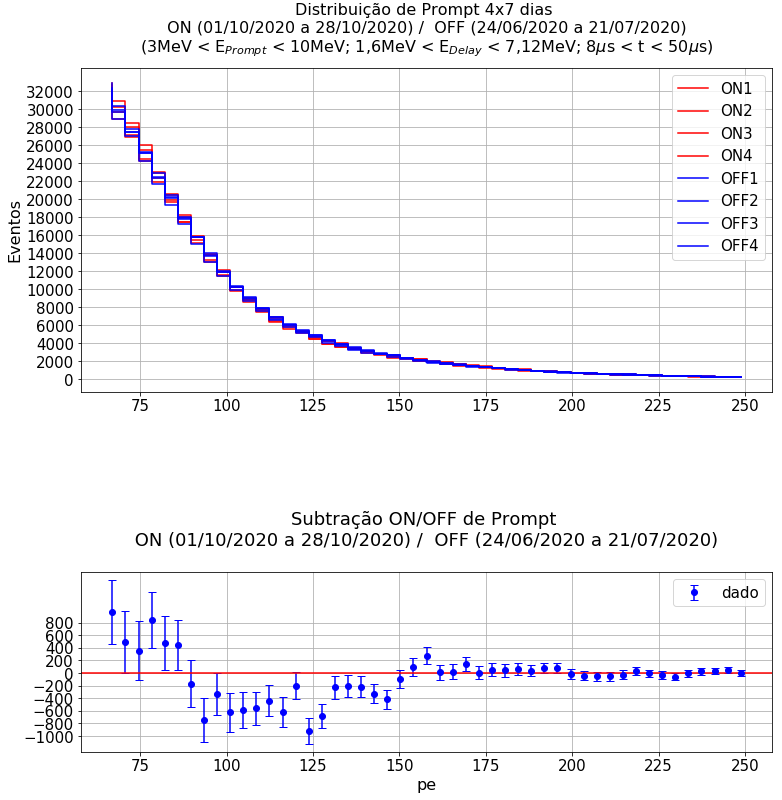

Excessos total
-3115
Excessos até 7MeV
-2600
Excessos até 6,5MeV
-774


In [99]:


fig=plt.figure(figsize=(12,5))

plt.rcParams.update({'font.size': 15})

maxElement = int(np.amax(h_PDP_ONO1)/5)

hist_ONO1, bins_ONO1 = np.histogram(h_PDP_ONO1, bins=maxElement)
hist_ONO2, bins_ONO2 = np.histogram(h_PDP_ONO2, bins=maxElement)
hist_ONO3, bins_ONO3 = np.histogram(h_PDP_ONO3, bins=maxElement)
hist_ONO4, bins_ONO4 = np.histogram(h_PDP_ONO4, bins=maxElement)
hist_OFF1, bins_OFF1 = np.histogram(h_PDP_OFF1, bins=maxElement)
hist_OFF2, bins_OFF2 = np.histogram(h_PDP_OFF2, bins=maxElement)
hist_OFF3, bins_OFF3 = np.histogram(h_PDP_OFF3, bins=maxElement)
hist_OFF4, bins_OFF4 = np.histogram(h_PDP_OFF4, bins=maxElement)

hist_ONO_A, bins_ONO_all = np.histogram(hist_ONO_all, bins=maxElement)
hist_OFF_A, bins_OFF_all = np.histogram(hist_OFF_all, bins=maxElement)

diff_hist = hist_ONO_A - hist_OFF_A  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

#print(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF)),hist1_OFF)

errbar_sigma_day = []
for inf in range(len(hist_ONO_A)):
    errbar_sigma_day.append((hist_ONO_A[inf] + hist_OFF_A[inf])**0.5)


axprops = dict(yticks=[])
axs = []

axs.append(fig.add_axes([0.1, 1.0, 0.8, 0.9], **axprops))
axs.append(fig.add_axes([0.1, 0, 0.8, 0.5], **axprops))

axs[0].plot(bins_ONO1[1:],hist_ONO1, '-', drawstyle='steps', color='red', label='ON1') ##bins_ON possui um elemento a mais sempre
axs[0].plot(bins_ONO2[1:],hist_ONO2, '-', drawstyle='steps', color='red', label='ON2') ##bins_ON possui um elemento a mais sempre
axs[0].plot(bins_ONO3[1:],hist_ONO3, '-', drawstyle='steps', color='red', label='ON3') ##bins_ON possui um elemento a mais sempre
axs[0].plot(bins_ONO4[1:],hist_ONO4, '-', drawstyle='steps', color='red', label='ON4') ##bins_ON possui um elemento a mais sempre
axs[0].plot(bins_OFF1[1:],hist_OFF1, '-', drawstyle='steps', color='blue', label='OFF1') 
axs[0].plot(bins_OFF2[1:],hist_OFF2, '-', drawstyle='steps', color='blue', label='OFF2') 
axs[0].plot(bins_OFF3[1:],hist_OFF3, '-', drawstyle='steps', color='blue', label='OFF3') 
axs[0].plot(bins_OFF4[1:],hist_OFF4, '-', drawstyle='steps', color='blue', label='OFF4') 
axs[1].errorbar(bins_OFF1[1:],diff_hist2[1:], yerr=errbar_sigma_day, #[1:] , 
                marker='o', color='blue', 
                linestyle='None', capsize=4, label='dado')

axs[0].grid(True)
axs[1].grid(True)

axs[1].axhline(0,color='red')

#axs[1].axhspan(np.std(diff_hist2), np.std(diff_hist2)*-1, color='green', alpha=0.5, label=r'1$\sigma$')
#axs[1].axhspan(np.std(diff_hist2)*2, np.std(diff_hist2)*-2, color='yellow', alpha=0.5, label=r'2$\sigma$')
#print(hist_ONO1[0])

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_ylabel('Eventos', size=16)
axs[1].set_xlabel('pe', size=16)
axs[0].set_yticks(np.arange(0, hist_ONO1[0],2000))
#axs[1].set_yticks(np.arange(diff_hist2[1]*-1, diff_hist2[1],200))
axs[1].set_yticks(np.arange(-1000, 1000, 200))

#tl_set1 = 'ON (20/08/2020 a 13/09/2020; 24/09/2020 a 28/09/2020)'

axs[0].set_title('Distribuição de Prompt 4x7 dias \n '+
                 'ON (01/10/2020 a 28/10/2020) / '+
                 ' OFF (24/06/2020 a 21/07/2020) \n'+
                 r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s)', size=16,y=1.02)
axs[1].set_title('Subtração ON/OFF de Prompt \n '+
                 'ON (01/10/2020 a 28/10/2020) / '+
                 ' OFF (24/06/2020 a 21/07/2020) \n')
#axs[0].set_ylim((20000, 33000))

#axs[1].annotate('Excessos total: {:d}'.format(sum(diff_hist2)), xy=(7.1, 670))
#plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

print('Excessos total')
print(sum(diff_hist2))
print('Excessos até 7MeV')
print(sum(diff_hist2[:19]))
print('Excessos até 6,5MeV')
print(sum(diff_hist2[:16]))


## FUNÇÃO PARA PLOTAGEM

In [29]:
def fnc_subtraction_ON_OFF (p_PDP_ON, p_PDP_OFF, s_lab_ON, s_lab_OFF):
    fig=plt.figure(figsize=(12,5))

    plt.rcParams.update({'font.size': 15})

    maxElement = int(np.amax(p_PDP_ON)/5)

    hist_ON3, bins_ON3 = np.histogram(p_PDP_ON, bins=maxElement)
    hist_OFF, bins_OFF = np.histogram(p_PDP_OFF, bins=maxElement)


    hist_ONO_A, bins_ONO_all = np.histogram(p_PDP_ON, bins=maxElement)
    hist_OFF_A, bins_OFF_all = np.histogram(p_PDP_OFF, bins=maxElement)

    diff_hist = hist_ONO_A - hist_OFF_A  # somente com prompt que está relacionado com a energia do neutrino
    diff_hist2 = np.append(diff_hist, [0])

    errbar_sigma_day = []
    for inf in range(len(hist_ONO_A)):
        errbar_sigma_day.append((hist_ONO_A[inf] + hist_OFF_A[inf])**0.5)
    

    axprops = dict(yticks=[])
    axs = []

    axs.append(fig.add_axes([0.1, 1.0, 0.8, 0.9], **axprops))
    axs.append(fig.add_axes([0.1, 0, 0.8, 0.5], **axprops))

    axs[0].plot(bins_ON3[1:],hist_ON3, '-', drawstyle='steps', color='red', label='ON') ##bins_ON possui um elemento a mais sempre
    axs[0].plot(bins_OFF[1:],hist_OFF, '-', drawstyle='steps', color='blue', label='OFF') 
    axs[1].errorbar(bins_OFF[1:],diff_hist2[1:], yerr=errbar_sigma_day, #[1:] , 
                    marker='o', color='blue', 
                    linestyle='None', capsize=4, label='dado')

    axs[0].grid(True)
    axs[1].grid(True)

    axs[1].axhline(0,color='red')

    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')
    axs[0].set_ylabel('Eventos', size=16)
    axs[1].set_xlabel('pe', size=16)
    axs[0].set_yticks(np.arange(0, hist_ON3[0],2000))
    axs[1].set_yticks(np.arange(-1000, 1000, 200))

    axs[0].set_title('Distribuição de Prompt 168 horas \n '+
                     s_lab_ON + ' / '+
                     s_lab_OFF + ' \n'+
                     r'(3MeV < E$_{Prompt}$ < 10MeV; 1,60MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; > 25PMTs)', size=16,y=1.02)
    axs[1].set_title('Subtração ON/OFF de Prompt \n '+
                     s_lab_ON + ' / '+
                     s_lab_OFF + ' \n')

    #plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
    plt.show()

    print('Excessos total')
    print(sum(diff_hist2))
    print('Excessos até 7MeV')
    print(sum(diff_hist2[:19]))
    print('Excessos até 6,5MeV')
    print(sum(diff_hist2[:16]))
    
    return(sum(diff_hist2[:19]))  ## retornando excessos até 7MeV


## Plot ON1 / OFF1

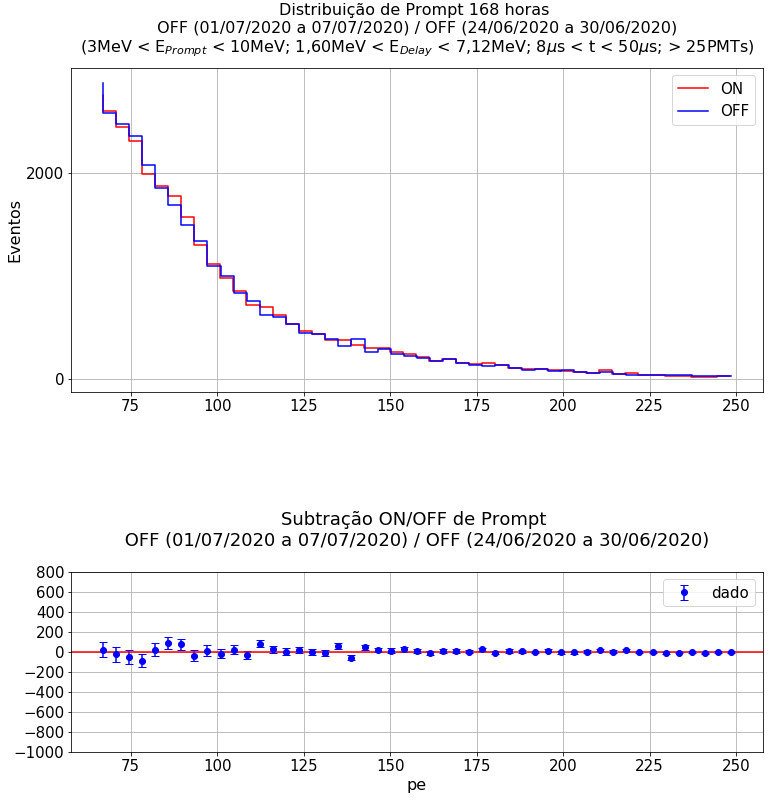

Excessos total
119
Excessos até 7MeV
-25
Excessos até 6,5MeV
-28


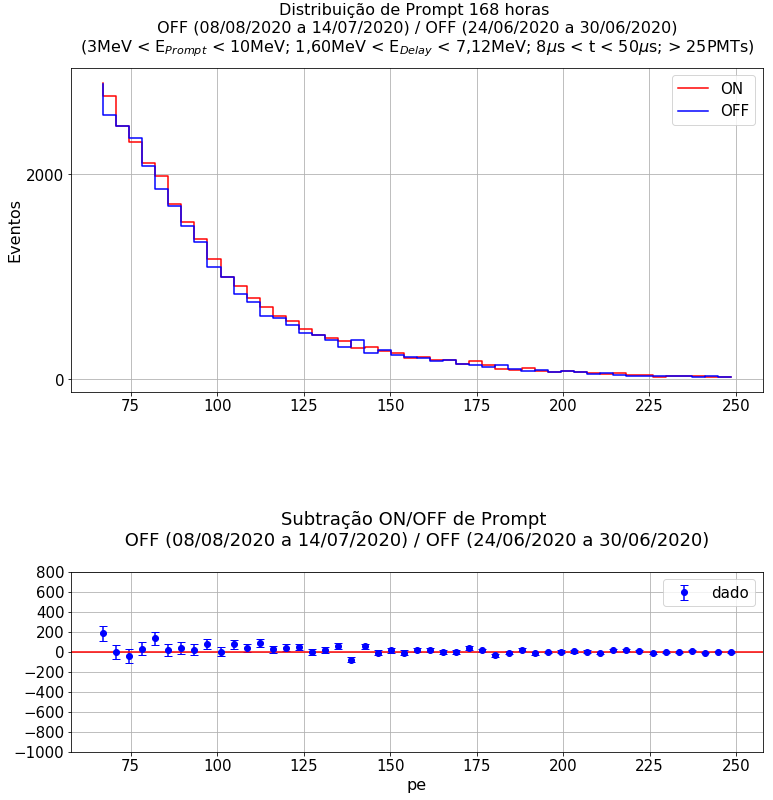

Excessos total
911
Excessos até 7MeV
807
Excessos até 6,5MeV
746


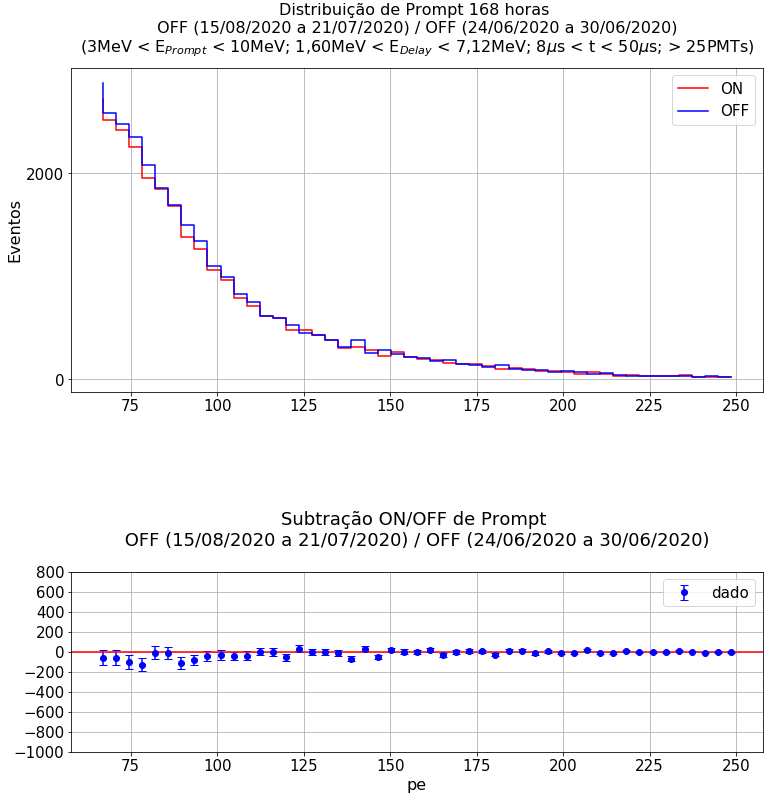

Excessos total
-1036
Excessos até 7MeV
-898
Excessos até 6,5MeV
-926


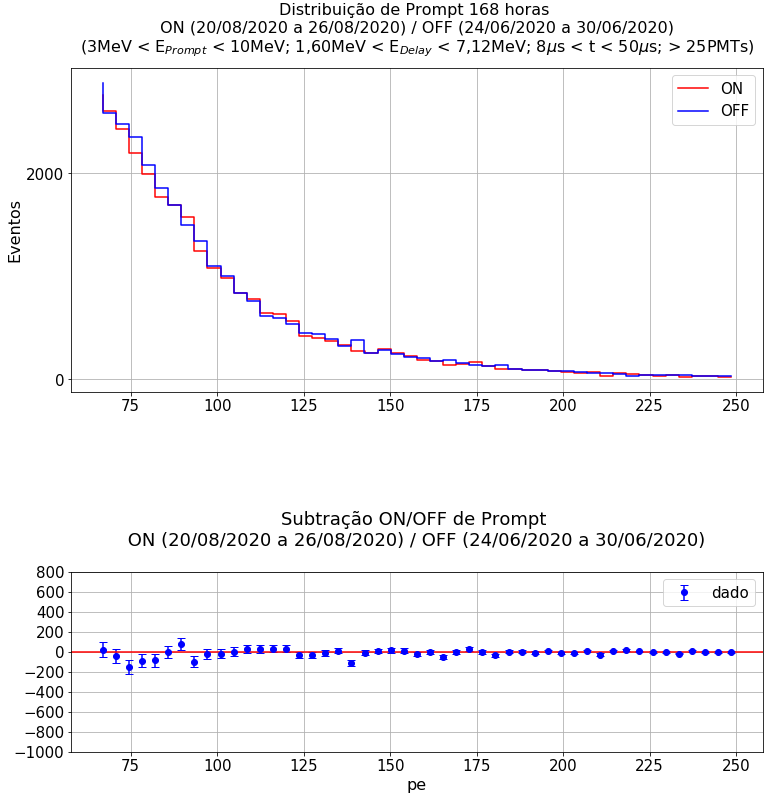

Excessos total
-707
Excessos até 7MeV
-508
Excessos até 6,5MeV
-428


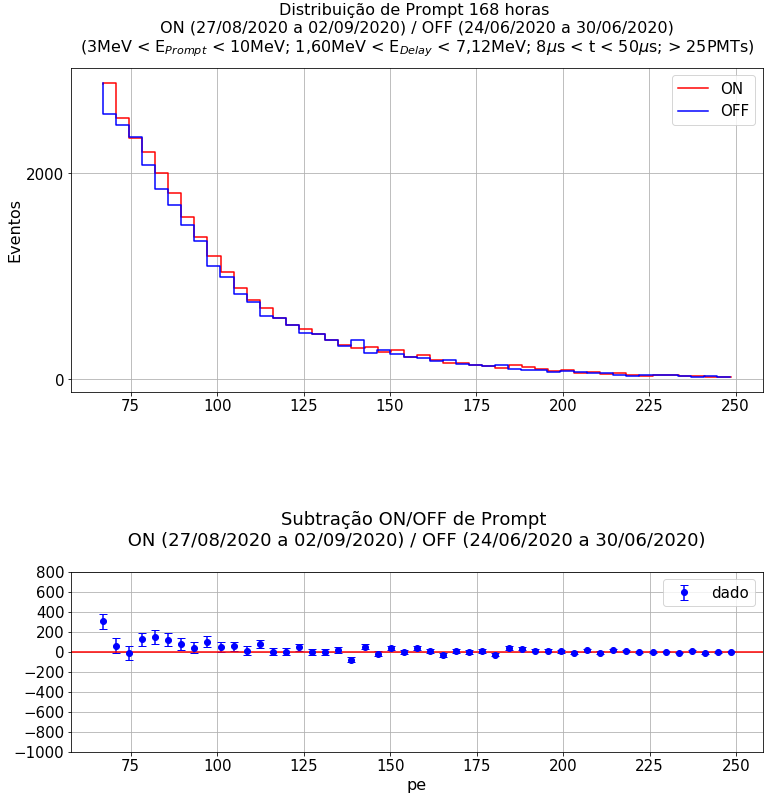

Excessos total
1319
Excessos até 7MeV
1204
Excessos até 6,5MeV
1161


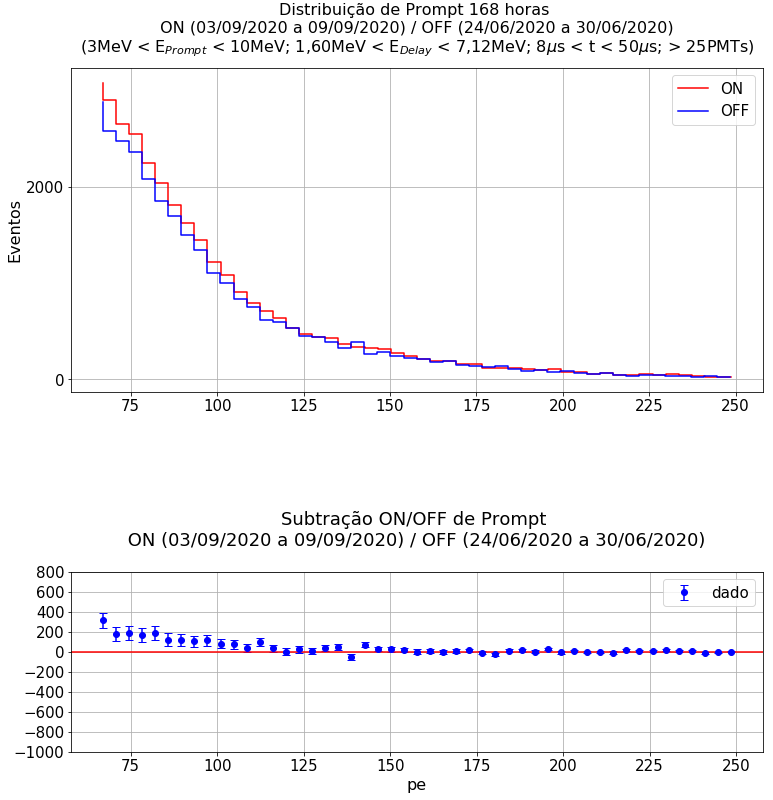

Excessos total
2337
Excessos até 7MeV
2095
Excessos até 6,5MeV
2025


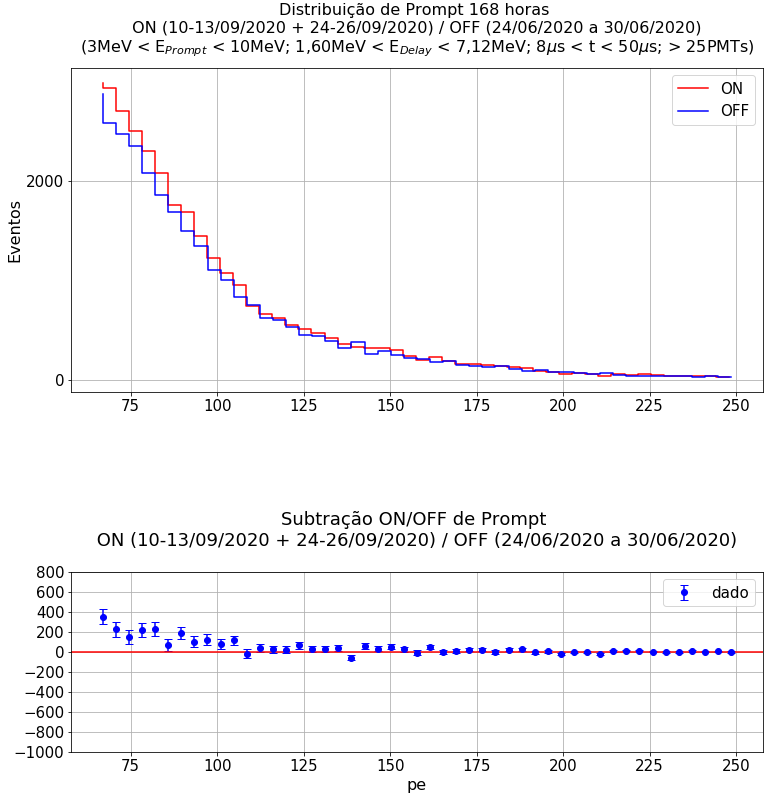

Excessos total
2431
Excessos até 7MeV
2158
Excessos até 6,5MeV
2033


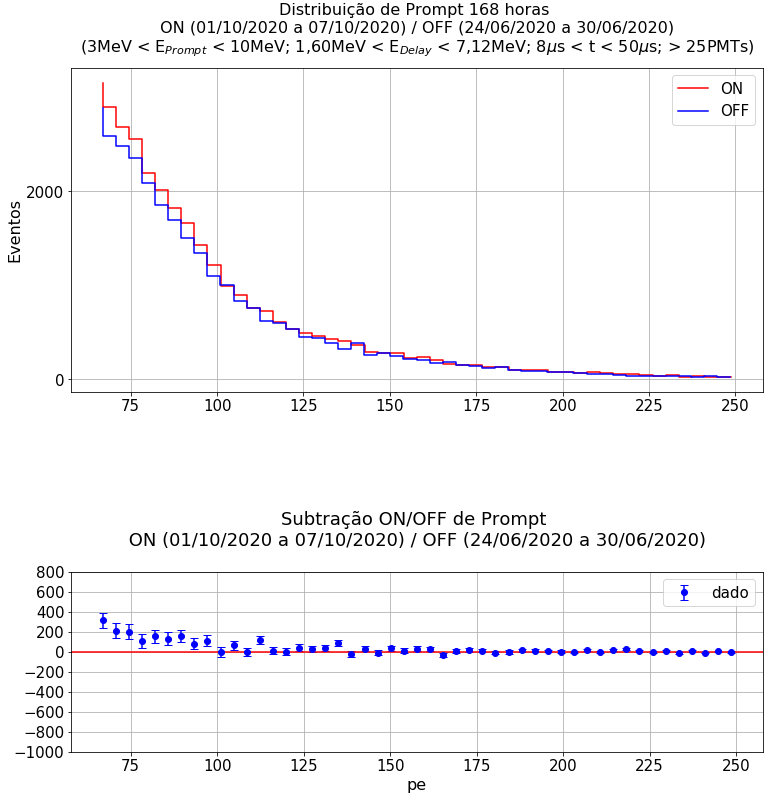

Excessos total
2331
Excessos até 7MeV
2046
Excessos até 6,5MeV
1933


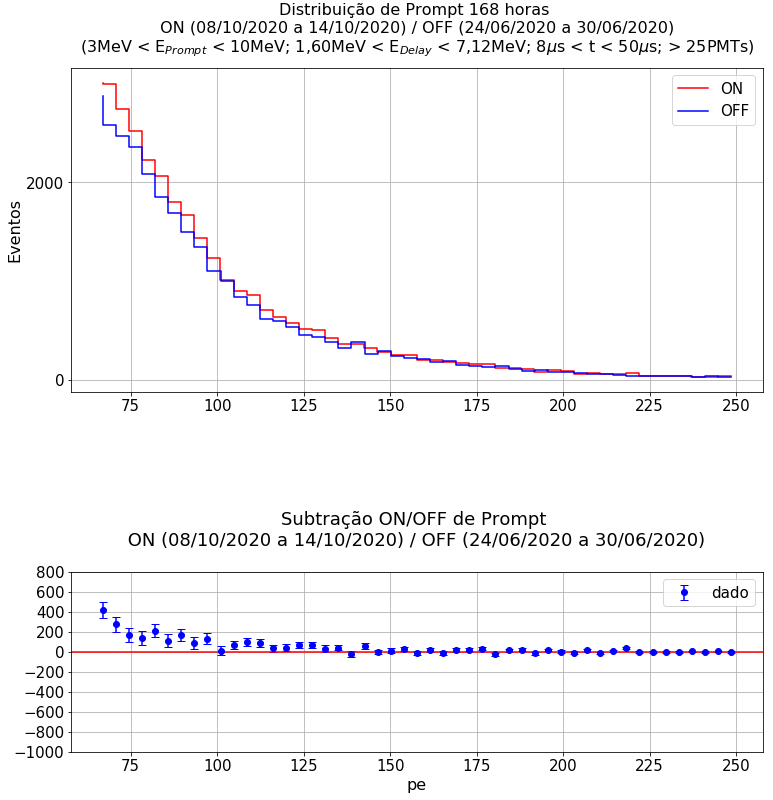

Excessos total
2622
Excessos até 7MeV
2369
Excessos até 6,5MeV
2197


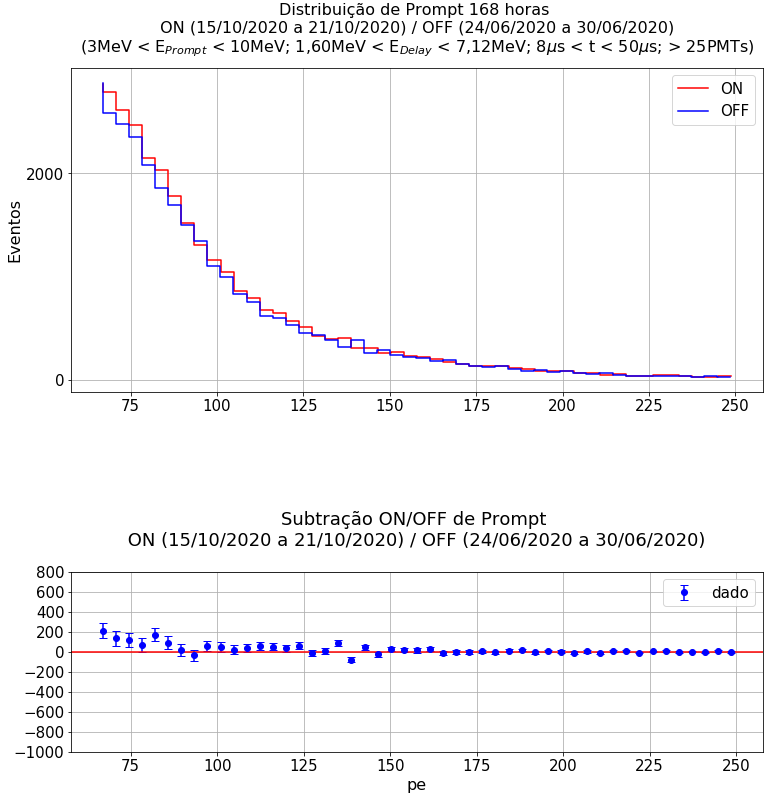

Excessos total
1273
Excessos até 7MeV
1139
Excessos até 6,5MeV
1078


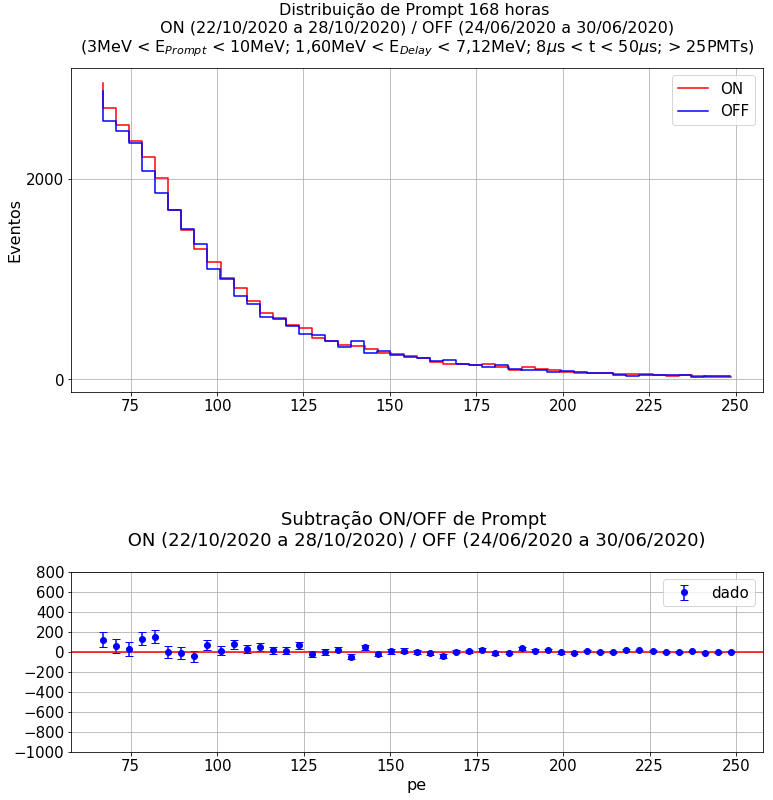

Excessos total
858
Excessos até 7MeV
806
Excessos até 6,5MeV
764


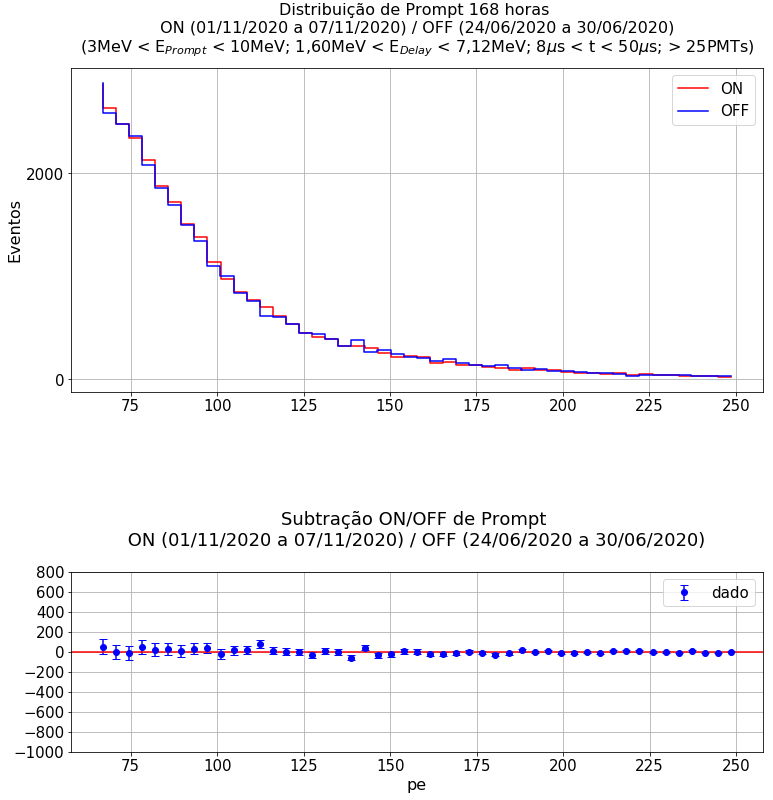

Excessos total
83
Excessos até 7MeV
268
Excessos até 6,5MeV
292


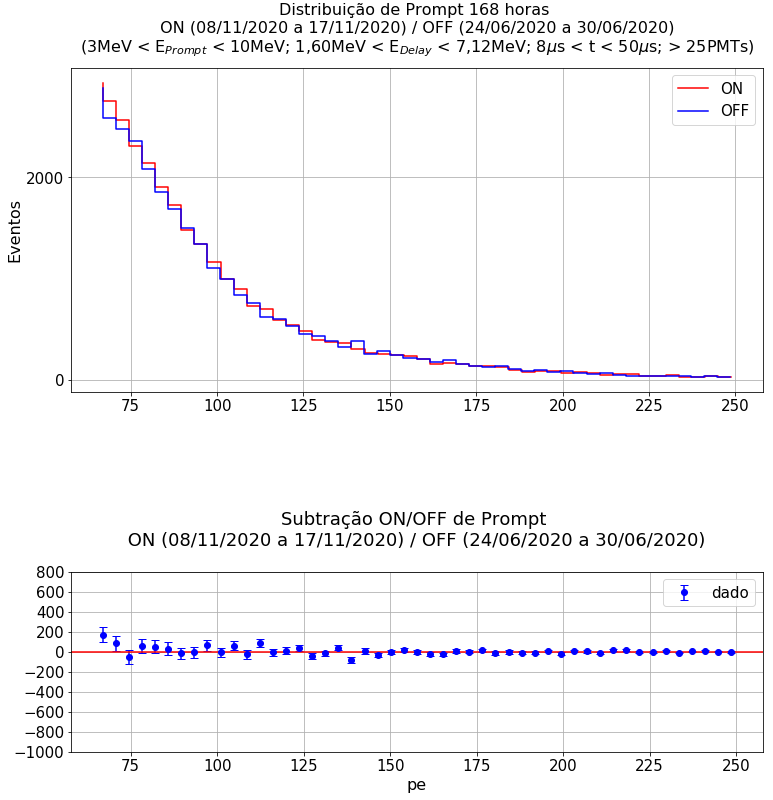

Excessos total
476
Excessos até 7MeV
544
Excessos até 6,5MeV
567


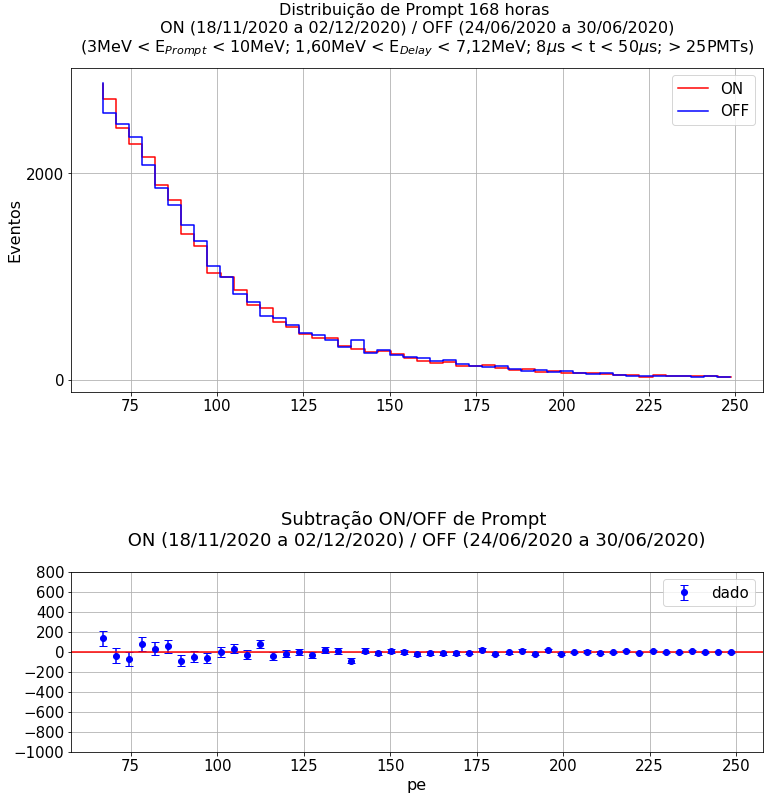

Excessos total
-183
Excessos até 7MeV
-26
Excessos até 6,5MeV
-8


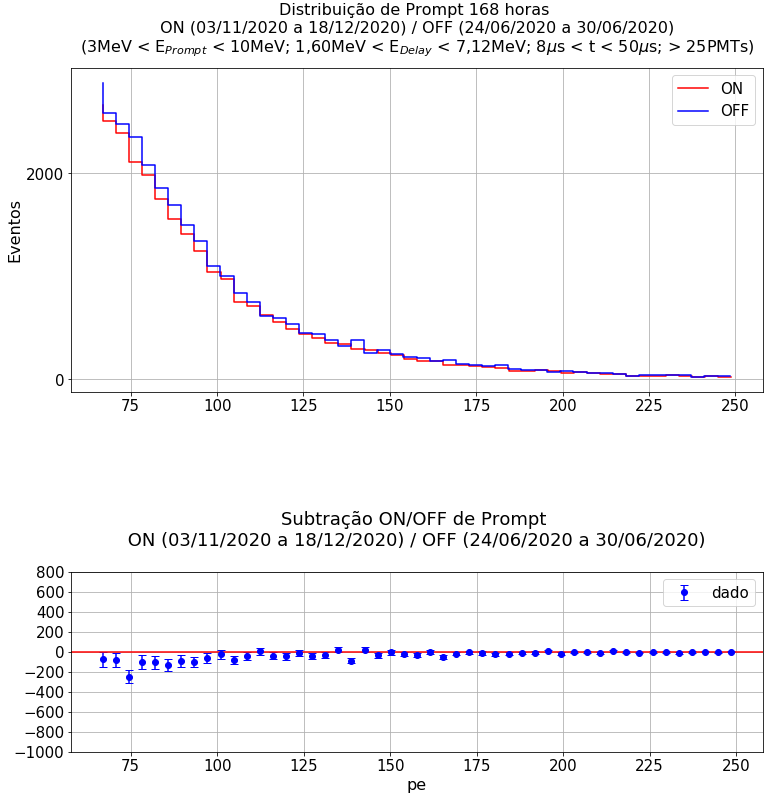

Excessos total
-1869
Excessos até 7MeV
-1539
Excessos até 6,5MeV
-1454


In [51]:
i_excess_OFF2 = fnc_subtraction_ON_OFF(h_PDP_OFF2, h_PDP_OFF1, 'OFF (01/07/2020 a 07/07/2020)', 'OFF (24/06/2020 a 30/06/2020)')
i_excess_OFF3 = fnc_subtraction_ON_OFF(h_PDP_OFF3, h_PDP_OFF1, 'OFF (08/08/2020 a 14/07/2020)', 'OFF (24/06/2020 a 30/06/2020)')
i_excess_OFF4 = fnc_subtraction_ON_OFF(h_PDP_OFF4, h_PDP_OFF1, 'OFF (15/08/2020 a 21/07/2020)', 'OFF (24/06/2020 a 30/06/2020)')
i_excess_ON1 = fnc_subtraction_ON_OFF(h_PDP_ON1, h_PDP_OFF1, 'ON (20/08/2020 a 26/08/2020)', 'OFF (24/06/2020 a 30/06/2020)')
i_excess_ON2 = fnc_subtraction_ON_OFF(h_PDP_ON2, h_PDP_OFF1, 'ON (27/08/2020 a 02/09/2020)', 'OFF (24/06/2020 a 30/06/2020)')
i_excess_ON3 = fnc_subtraction_ON_OFF(h_PDP_ON3, h_PDP_OFF1, 'ON (03/09/2020 a 09/09/2020)', 'OFF (24/06/2020 a 30/06/2020)')
i_excess_ON4 = fnc_subtraction_ON_OFF(h_PDP_ON4, h_PDP_OFF1, 'ON (10-13/09/2020 + 24-26/09/2020)', 'OFF (24/06/2020 a 30/06/2020)')
i_excess_ONO1 = fnc_subtraction_ON_OFF(h_PDP_ONO1, h_PDP_OFF1, 'ON (01/10/2020 a 07/10/2020)', 'OFF (24/06/2020 a 30/06/2020)')
i_excess_ONO2 = fnc_subtraction_ON_OFF(h_PDP_ONO2, h_PDP_OFF1, 'ON (08/10/2020 a 14/10/2020)', 'OFF (24/06/2020 a 30/06/2020)')
i_excess_ONO3 = fnc_subtraction_ON_OFF(h_PDP_ONO3, h_PDP_OFF1, 'ON (15/10/2020 a 21/10/2020)', 'OFF (24/06/2020 a 30/06/2020)')
i_excess_ONO4 = fnc_subtraction_ON_OFF(h_PDP_ONO4, h_PDP_OFF1, 'ON (22/10/2020 a 28/10/2020)', 'OFF (24/06/2020 a 30/06/2020)')
i_excess_ONN1 = fnc_subtraction_ON_OFF(h_PDP_ONN1, h_PDP_OFF1, 'ON (01/11/2020 a 07/11/2020)', 'OFF (24/06/2020 a 30/06/2020)')
i_excess_ONN2 = fnc_subtraction_ON_OFF(h_PDP_ONN2, h_PDP_OFF1, 'ON (08/11/2020 a 17/11/2020)', 'OFF (24/06/2020 a 30/06/2020)')
i_excess_ONN3 = fnc_subtraction_ON_OFF(h_PDP_ONN3, h_PDP_OFF1, 'ON (18/11/2020 a 02/12/2020)', 'OFF (24/06/2020 a 30/06/2020)')
i_excess_ONN4 = fnc_subtraction_ON_OFF(h_PDP_ONN4, h_PDP_OFF1, 'ON (03/11/2020 a 18/12/2020)', 'OFF (24/06/2020 a 30/06/2020)')





## Contagem de excessos

No handles with labels found to put in legend.


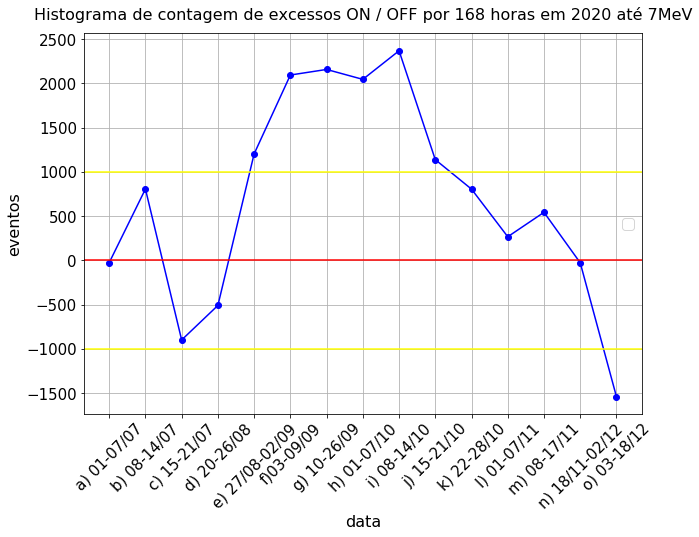

In [77]:
fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

#ax.set_ylim([1000, 8000])
ax.tick_params(axis='x', labelrotation=45)

#ii = 0

#for sDate_i in listProcess:
#    plt.plot(sDate_i, listPerInterval[ii],'bo')       
#    ii+=1
v_data_excess = ['a) 01-07/07','b) 08-14/07','c) 15-21/07','d) 20-26/08','e) 27/08-02/09','f)03-09/09','g) 10-26/09',
                'h) 01-07/10','i) 08-14/10','j) 15-21/10','k) 22-28/10','l) 01-07/11','m) 08-17/11','n) 18/11-02/12','o) 03-18/12']
v_excess = [i_excess_OFF2,i_excess_OFF3,i_excess_OFF4,i_excess_ON1,i_excess_ON2,i_excess_ON3,i_excess_ON4,
           i_excess_ONO1,i_excess_ONO2,i_excess_ONO3,i_excess_ONO4,i_excess_ONN1,i_excess_ONN2,i_excess_ONN3,i_excess_ONN4]

plt.plot(v_data_excess, v_excess,'bo-')       

plt.axhline(0,color='red')
plt.axhline(1000,color='yellow')
plt.axhline(-1000,color='yellow')

'''

plt.plot('01-07/07', i_excess_OFF2,'bo-')       
plt.plot('08-14/07', i_excess_OFF3,'bo-')       
plt.plot('15-21/07', i_excess_OFF4,'bo-')       
plt.plot('20-26/08', i_excess_ON1,'bo-')       
plt.plot('27/08-02/09', i_excess_ON2,'bo-')       
plt.plot('03-09/09', i_excess_ON3,'bo-')       
plt.plot('10-26/09', i_excess_ON4,'bo-')       
plt.plot('01-07/10', i_excess_ONO1,'bo-')       
plt.plot('08-14/10', i_excess_ONO2,'bo-')       
plt.plot('15-21/10', i_excess_ONO3,'bo-')       
plt.plot('22-28/10', i_excess_ONO4,'bo-')       
plt.plot('01-07/11', i_excess_ONN1,'bo-')       
plt.plot('08-17/11', i_excess_ONN2,'bo-')       
plt.plot('18/11-02/12', i_excess_ONN3,'bo-')       
plt.plot('03-18/12', i_excess_ONN4,'bo-')  


v_sig_excess = [(abs(a)**.5) for a in v_excess]

plt.errorbar(v_data_excess, v_excess,
             yerr=v_sig_excess, marker='o', color='blue', 
                    linestyle='None', capsize=4)
'''  


plt.legend(loc='center right')
plt.grid(True)

plt.ylabel('eventos', size=16)
plt.xlabel('data', size=16)
plt.title('Histograma de contagem de excessos ON / OFF por 168 horas em 2020 até 7MeV', size=16,y=1.02)
#plt.subtitle('cortes: não-saturados, delay: 25PMTs e 1,6-7,12MeV ')
plt.savefig('histogramas/Hist_Excessos_2020_ONOFF.png')
plt.show()

## Plot ONN1 / OFF1

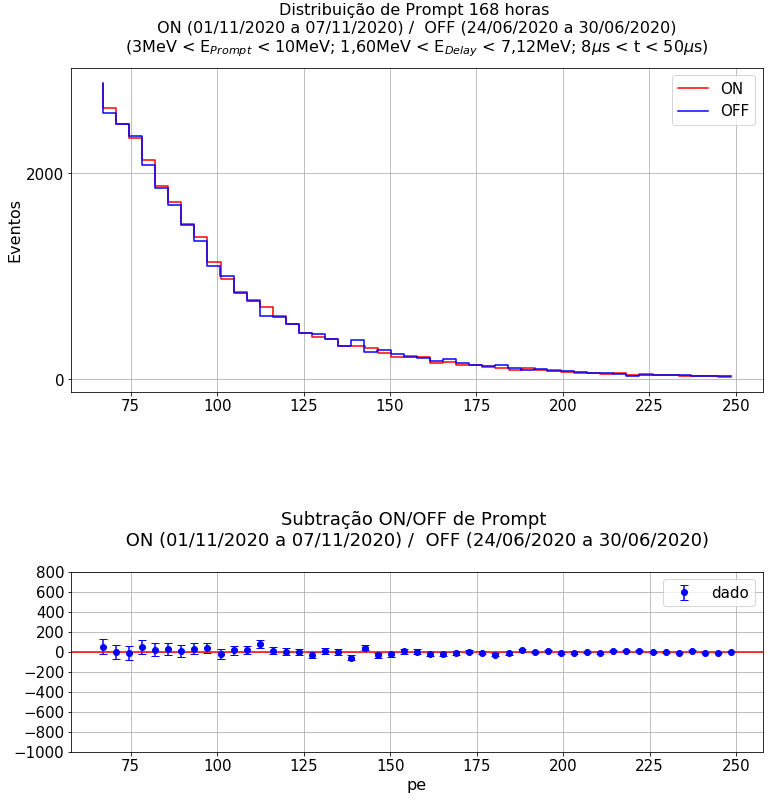

Excessos total
83
Excessos até 7MeV
268
Excessos até 6,5MeV
292


In [16]:
fig=plt.figure(figsize=(12,5))

plt.rcParams.update({'font.size': 15})

maxElement = int(np.amax(h_PDP_ONN1)/5)

hist_ON3, bins_ON3 = np.histogram(h_PDP_ONN1, bins=maxElement)
hist_OFF, bins_OFF = np.histogram(h_PDP_OFF1, bins=maxElement)


hist_ONO_A, bins_ONO_all = np.histogram(h_PDP_ONN1, bins=maxElement)
hist_OFF_A, bins_OFF_all = np.histogram(h_PDP_OFF1, bins=maxElement)

diff_hist = hist_ONO_A - hist_OFF_A  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

errbar_sigma_day = []
for inf in range(len(hist_ONO_A)):
    errbar_sigma_day.append((hist_ONO_A[inf] + hist_OFF_A[inf])**0.5)


axprops = dict(yticks=[])
axs = []

axs.append(fig.add_axes([0.1, 1.0, 0.8, 0.9], **axprops))
axs.append(fig.add_axes([0.1, 0, 0.8, 0.5], **axprops))

axs[0].plot(bins_ON3[1:],hist_ON3, '-', drawstyle='steps', color='red', label='ON') ##bins_ON possui um elemento a mais sempre
axs[0].plot(bins_OFF[1:],hist_OFF, '-', drawstyle='steps', color='blue', label='OFF') 
axs[1].errorbar(bins_OFF[1:],diff_hist2[1:], yerr=errbar_sigma_day, #[1:] , 
                marker='o', color='blue', 
                linestyle='None', capsize=4, label='dado')

axs[0].grid(True)
axs[1].grid(True)

axs[1].axhline(0,color='red')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_ylabel('Eventos', size=16)
axs[1].set_xlabel('pe', size=16)
axs[0].set_yticks(np.arange(0, hist_ON3[0],2000))
axs[1].set_yticks(np.arange(-1000, 1000, 200))

axs[0].set_title('Distribuição de Prompt 168 horas \n '+
                 'ON (01/11/2020 a 07/11/2020) / '+
                 ' OFF (24/06/2020 a 30/06/2020) \n'+
                 r'(3MeV < E$_{Prompt}$ < 10MeV; 1,60MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s)', size=16,y=1.02)
axs[1].set_title('Subtração ON/OFF de Prompt \n '+
                 'ON (01/11/2020 a 07/11/2020) / '+
                 ' OFF (24/06/2020 a 30/06/2020) \n')

#plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

print('Excessos total')
print(sum(diff_hist2))
print('Excessos até 7MeV')
print(sum(diff_hist2[:19]))
print('Excessos até 6,5MeV')
print(sum(diff_hist2[:16]))

## Plot ONO4 / OFF1

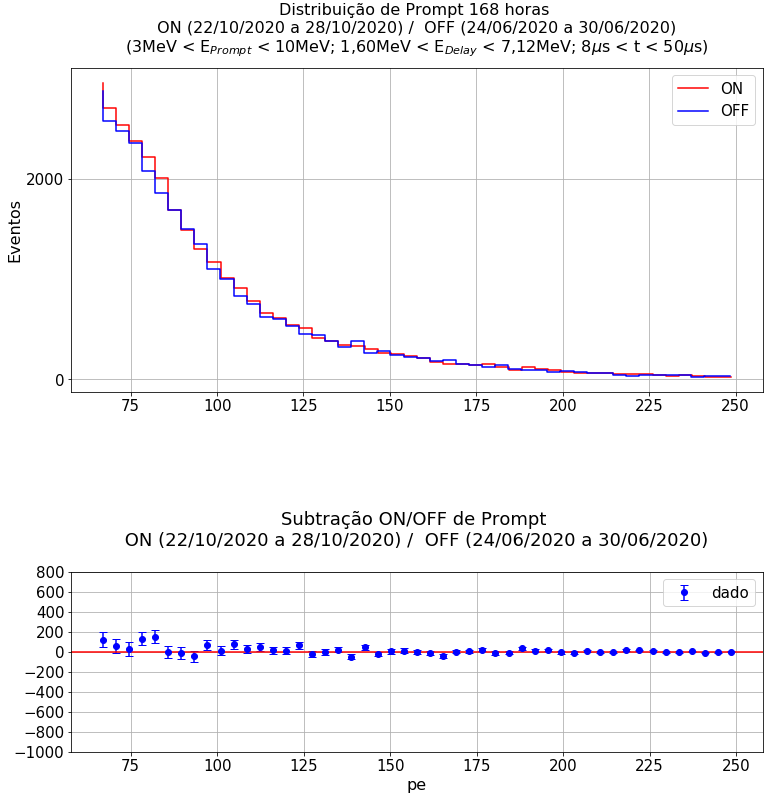

Excessos total
858
Excessos até 7MeV
806
Excessos até 6,5MeV
764


In [17]:
fig=plt.figure(figsize=(12,5))

plt.rcParams.update({'font.size': 15})

maxElement = int(np.amax(h_PDP_ONO4)/5)

hist_ON3, bins_ON3 = np.histogram(h_PDP_ONO4, bins=maxElement)
hist_OFF, bins_OFF = np.histogram(h_PDP_OFF1, bins=maxElement)


hist_ONO_A, bins_ONO_all = np.histogram(h_PDP_ONO4, bins=maxElement)
hist_OFF_A, bins_OFF_all = np.histogram(h_PDP_OFF1, bins=maxElement)

diff_hist = hist_ONO_A - hist_OFF_A  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

errbar_sigma_day = []
for inf in range(len(hist_ONO_A)):
    errbar_sigma_day.append((hist_ONO_A[inf] + hist_OFF_A[inf])**0.5)


axprops = dict(yticks=[])
axs = []

axs.append(fig.add_axes([0.1, 1.0, 0.8, 0.9], **axprops))
axs.append(fig.add_axes([0.1, 0, 0.8, 0.5], **axprops))

axs[0].plot(bins_ON3[1:],hist_ON3, '-', drawstyle='steps', color='red', label='ON') ##bins_ON possui um elemento a mais sempre
axs[0].plot(bins_OFF[1:],hist_OFF, '-', drawstyle='steps', color='blue', label='OFF') 
axs[1].errorbar(bins_OFF[1:],diff_hist2[1:], yerr=errbar_sigma_day, #[1:] , 
                marker='o', color='blue', 
                linestyle='None', capsize=4, label='dado')

axs[0].grid(True)
axs[1].grid(True)

axs[1].axhline(0,color='red')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_ylabel('Eventos', size=16)
axs[1].set_xlabel('pe', size=16)
axs[0].set_yticks(np.arange(0, hist_ON3[0],2000))
axs[1].set_yticks(np.arange(-1000, 1000, 200))

axs[0].set_title('Distribuição de Prompt 168 horas \n '+
                 'ON (22/10/2020 a 28/10/2020) / '+
                 ' OFF (24/06/2020 a 30/06/2020) \n'+
                 r'(3MeV < E$_{Prompt}$ < 10MeV; 1,60MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s)', size=16,y=1.02)
axs[1].set_title('Subtração ON/OFF de Prompt \n '+
                 'ON (22/10/2020 a 28/10/2020) / '+
                 ' OFF (24/06/2020 a 30/06/2020) \n')

#plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

print('Excessos total')
print(sum(diff_hist2))
print('Excessos até 7MeV')
print(sum(diff_hist2[:19]))
print('Excessos até 6,5MeV')
print(sum(diff_hist2[:16]))

## Plot ONO1 / OFF1

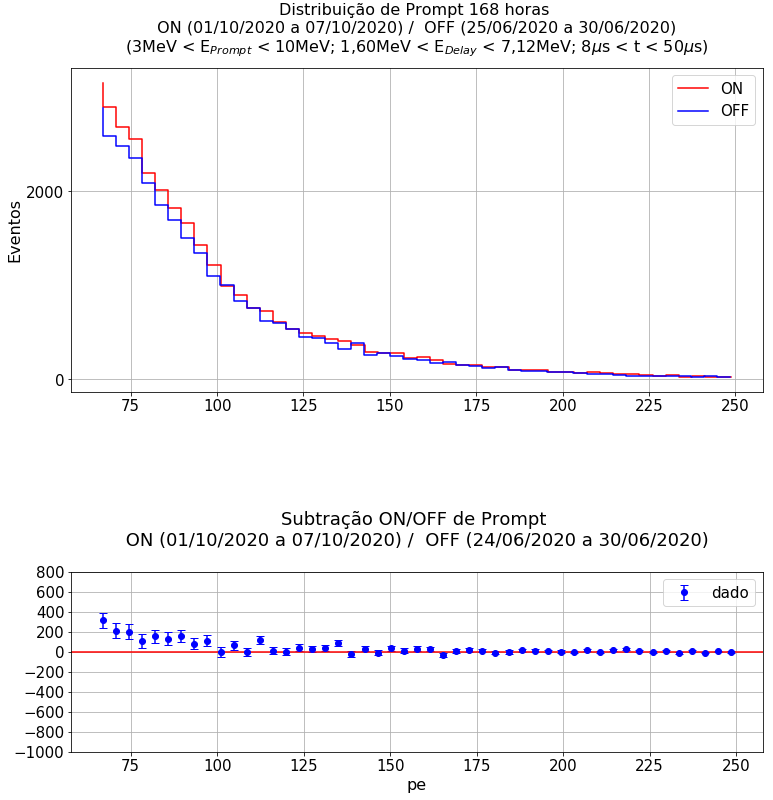

Excessos total
2331
Excessos até 7MeV
2046
Excessos até 6,5MeV
1933


In [19]:
fig=plt.figure(figsize=(12,5))

plt.rcParams.update({'font.size': 15})

maxElement = int(np.amax(h_PDP_ONO1)/5)

hist_ON3, bins_ON3 = np.histogram(h_PDP_ONO1, bins=maxElement)
hist_OFF, bins_OFF = np.histogram(h_PDP_OFF1, bins=maxElement)


hist_ONO_A, bins_ONO_all = np.histogram(h_PDP_ONO1, bins=maxElement)
hist_OFF_A, bins_OFF_all = np.histogram(h_PDP_OFF1, bins=maxElement)

diff_hist = hist_ONO_A - hist_OFF_A  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

errbar_sigma_day = []
for inf in range(len(hist_ONO_A)):
    errbar_sigma_day.append((hist_ONO_A[inf] + hist_OFF_A[inf])**0.5)


axprops = dict(yticks=[])
axs = []

axs.append(fig.add_axes([0.1, 1.0, 0.8, 0.9], **axprops))
axs.append(fig.add_axes([0.1, 0, 0.8, 0.5], **axprops))

axs[0].plot(bins_ON3[1:],hist_ON3, '-', drawstyle='steps', color='red', label='ON') ##bins_ON possui um elemento a mais sempre
axs[0].plot(bins_OFF[1:],hist_OFF, '-', drawstyle='steps', color='blue', label='OFF') 
axs[1].errorbar(bins_OFF[1:],diff_hist2[1:], yerr=errbar_sigma_day, #[1:] , 
                marker='o', color='blue', 
                linestyle='None', capsize=4, label='dado')

axs[0].grid(True)
axs[1].grid(True)

axs[1].axhline(0,color='red')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_ylabel('Eventos', size=16)
axs[1].set_xlabel('pe', size=16)
axs[0].set_yticks(np.arange(0, hist_ON3[0],2000))
axs[1].set_yticks(np.arange(-1000, 1000, 200))

axs[0].set_title('Distribuição de Prompt 168 horas \n '+
                 'ON (01/10/2020 a 07/10/2020) / '+
                 ' OFF (25/06/2020 a 30/06/2020) \n'+
                 r'(3MeV < E$_{Prompt}$ < 10MeV; 1,60MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s)', size=16,y=1.02)
axs[1].set_title('Subtração ON/OFF de Prompt \n '+
                 'ON (01/10/2020 a 07/10/2020) / '+
                 ' OFF (24/06/2020 a 30/06/2020) \n')

#plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

print('Excessos total')
print(sum(diff_hist2))
print('Excessos até 7MeV')
print(sum(diff_hist2[:19]))
print('Excessos até 6,5MeV')
print(sum(diff_hist2[:16]))

## Salvando em formato CSV

In [78]:
##save values - h_Sig_OFF2 (contém o sigma de cada bin dividido por 5dias)
def save_CSV (dh_Hist, dh_Bins, sName):
    # dictionary of lists
    dict = {'Eventos': dh_Hist,
            'Bin': dh_Bins}
    
    # creating a dataframe from dictionary
    dfw = pd.DataFrame(dict)
    dfw.to_csv('data/Analise_ONOFF/'+sName+'.csv', index=False, sep=';')

    del dict

##save values - h_Sig_OFF2 (contém o sigma de cada bin dividido por 5dias)
def save_CSV_sub (dh_Hist, dh_Bins, dh_Err, sName):
    # dictionary of lists
    dict = {'Eventos': dh_Hist,
            'Bin': dh_Bins,
            'Err': dh_Err}
    
    # creating a dataframe from dictionary
    dfw = pd.DataFrame(dict)
    dfw.to_csv('data/Analise_ONOFF/'+sName+'.csv', index=False, sep=';')

    del dict

In [71]:

save_CSV (hist_ONO1[1:], bins_ONO1[1:-1], 'ON1_01Out2020_crit_7d')
save_CSV (hist_ONO2[1:], bins_ONO2[1:-1], 'ON2_08Out2020_crit_7d')
save_CSV (hist_ONO3[1:], bins_ONO3[1:-1], 'ON3_15Out2020_crit_7d')
save_CSV (hist_ONO4[1:], bins_ONO4[1:-1], 'ON4_22Out2020_crit_7d')
save_CSV (hist_OFF1[1:], bins_OFF1[1:-1], 'OFF1_24Jun2020_crit_7d')
save_CSV (hist_OFF2[1:], bins_OFF2[1:-1], 'OFF2_01Jul2020_crit_7d')
save_CSV (hist_OFF3[1:], bins_OFF3[1:-1], 'OFF3_08Jul2020_crit_7d')
save_CSV (hist_OFF4[1:], bins_OFF4[1:-1], 'OFF4_15Jul2020_crit_7d')

save_CSV (hist_ONO_A[1:], bins_ONO1[1:-1], 'Sum_ON_2020_crit_28d')
save_CSV (hist_OFF_A[1:], bins_OFF1[1:-1], 'Sum_OFF_2020_crit_28d')

save_CSV_sub (diff_hist2[1:], bins_OFF1[1:], errbar_sigma_day, 'SUB_2020_crit_28d')


## Salva arquivos 168 horas em CSV (versão 3)

In [ ]:
save_PD (h_PDP_OFF1, h_MUP_OFF1, h_PDD_OFF1, h_MUD_OFF1, h_PDT_OFF1, hg_Sig_OFF1, 'PD_OFF1_7d_v3')
save_PD (h_PDP_OFF2, h_MUP_OFF2, h_PDD_OFF2, h_MUD_OFF2, h_PDT_OFF2, hg_Sig_OFF2, 'PD_OFF2_7d_v3')
save_PD (h_PDP_OFF3, h_MUP_OFF3, h_PDD_OFF3, h_MUD_OFF3, h_PDT_OFF3, hg_Sig_OFF3, 'PD_OFF3_7d_v3')
save_PD (h_PDP_OFF4, h_MUP_OFF4, h_PDD_OFF4, h_MUD_OFF4, h_PDT_OFF4, hg_Sig_OFF4, 'PD_OFF4_7d_v3')

save_PD (h_PDP_ON1, h_MUP_ON1, h_PDD_ON1, h_MUD_ON1, h_PDT_ON1, hg_Sig_ON1, 'PD_ON1_7d_v3')
save_PD (h_PDP_ON2, h_MUP_ON2, h_PDD_ON2, h_MUD_ON2, h_PDT_ON2, hg_Sig_ON2, 'PD_ON2_7d_v3')
save_PD (h_PDP_ON3, h_MUP_ON3, h_PDD_ON3, h_MUD_ON3, h_PDT_ON3, hg_Sig_ON3, 'PD_ON3_7d_v3')
save_PD (h_PDP_ON4, h_MUP_ON4, h_PDD_ON4, h_MUD_ON4, h_PDT_ON4, hg_Sig_ON4, 'PD_ON4_7d_v3')

save_PD (h_PDP_ONO1, h_MUP_ONO1, h_PDD_ONO1, h_MUD_ONO1, h_PDT_ONO1, hg_Sig_ONO1, 'PD_ONO1_7d_v3')
save_PD (h_PDP_ONO2, h_MUP_ONO2, h_PDD_ONO2, h_MUD_ONO2, h_PDT_ONO2, hg_Sig_ONO2, 'PD_ONO2_7d_v3')
save_PD (h_PDP_ONO3, h_MUP_ONO3, h_PDD_ONO3, h_MUD_ONO3, h_PDT_ONO3, hg_Sig_ONO3, 'PD_ONO3_7d_v3')
save_PD (h_PDP_ONO4, h_MUP_ONO4, h_PDD_ONO4, h_MUD_ONO4, h_PDT_ONO4, hg_Sig_ONO4, 'PD_ONO4_7d_v3')

save_PD (h_PDP_ONN1, h_MUP_ONN1, h_PDD_ONN1, h_MUD_ONN1, h_PDT_ONN1, hg_Sig_ONN1, 'PD_ONN1_7d_v3')
save_PD (h_PDP_ONN2, h_MUP_ONN2, h_PDD_ONN2, h_MUD_ONN2, h_PDT_ONN2, hg_Sig_ONN2, 'PD_ONN2_7d_v3')
save_PD (h_PDP_ONN3, h_MUP_ONN3, h_PDD_ONN3, h_MUD_ONN3, h_PDT_ONN3, hg_Sig_ONN3, 'PD_ONN3_7d_v3')
save_PD (h_PDP_ONN4, h_MUP_ONN4, h_PDD_ONN4, h_MUD_ONN4, h_PDT_ONN4, hg_Sig_ONN4, 'PD_ONN4_7d_v3')


## Salvando em formato XML

In [84]:
import xml.etree.ElementTree as ET

##save values - h_Sig_OFF2 (contém o sigma de cada bin dividido por 5dias)
def save_XML (dh_Hist, dh_Bins, sName):
    # dictionary of lists
    #dict = {'Eventos': dh_Hist,
    #        'Bin': dh_Bins}
    
    # creating a dataframe from dictionary
    #dfw = pd.DataFrame(dict)
    #dfw.to_csv('data/Analise_ONOFF/'+sName+'.csv', index=False, sep=';')
    
    
    data = ET.Element('ONOFF')
    
    for indh in range(len(dh_Hist)):
        e_Hist = str(dh_Hist[indh])
        e_Bin = str(dh_Bins[indh])
 
        element1 = ET.SubElement(data, 'Hist')
        element2 = ET.SubElement(data, 'Bin')

        element1.text = e_Hist
        element2.text = e_Bin
 
        #s_elem1 = ET.SubElement(element1, 'E4')
        #s_elem2 = ET.SubElement(element1, 'D4')
 
        # Adding attributes to the tags under
        #s_elem1.set('type', 'Accepted')
        #s_elem2.set('type', 'Declined')
 
 
    b_xml = ET.tostring(data)
 
    with open('data/Analise_ONOFF/'+sName+'.xml', "wb") as f:
        f.write(b_xml)
    
    #del dict

##save values - h_Sig_OFF2 (contém o sigma de cada bin dividido por 5dias)
#def save_XML_sub (dh_Hist, dh_Bins, dh_Err, sName):
    # dictionary of lists
#    dict = {'Eventos': dh_Hist,
#            'Bin': dh_Bins,
#            'Err': dh_Err}
    
    # creating a dataframe from dictionary
#    dfw = pd.DataFrame(dict)
#    dfw.to_csv('data/Analise_ONOFF/'+sName+'.csv', index=False, sep=';')

#    del dict

In [85]:
save_XML (hist_ONO1[1:], bins_ONO1[1:-1], 'ON1_01Out2020_crit_7d_w')

## Scatter PE x Multiplicidade

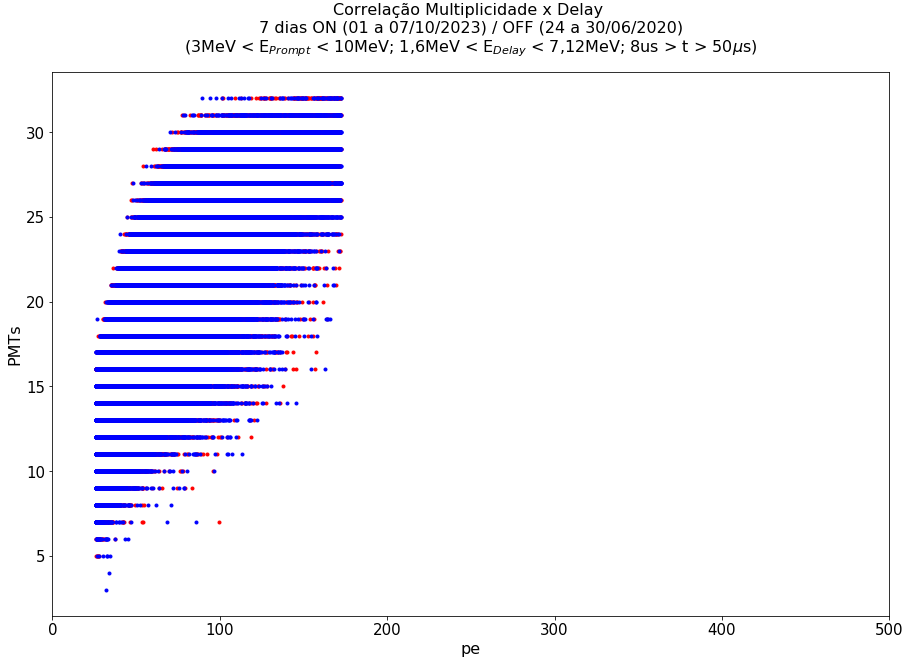

In [78]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 15})

plt.scatter(h_PDD_ONO1, h_MUD_ONO1, marker='.', color='red')
plt.scatter(h_PDD_OFF1, h_MUD_OFF1, marker='.', color='blue')
plt.ylabel('PMTs', size=16)
plt.xlabel('pe', size=16)
plt.xlim(0,500)
plt.title('Correlação Multiplicidade x Delay \n'+
          ' 7 dias ON (01 a 07/10/2023) / OFF (24 a 30/06/2020) \n'+
        r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8us > t > 50$\mu$s)', size=16,y=1.02)
plt.show()
#plt.savefig('histogramas/Scatter_Mult_Back_t_50.png')

## Histograma de Multiplicidade - Delay

In [19]:
hist_MUD_ONO_all = []
hist_MUD_ONO_all.extend(h_MUD_ONO1)
hist_MUD_ONO_all.extend(h_MUD_ONO2)
hist_MUD_ONO_all.extend(h_MUD_ONO3)
hist_MUD_ONO_all.extend(h_MUD_ONO4)
hist_MUD_OFF_all = []
hist_MUD_OFF_all.extend(h_MUD_OFF1)
hist_MUD_OFF_all.extend(h_MUD_OFF2)
hist_MUD_OFF_all.extend(h_MUD_OFF3)
hist_MUD_OFF_all.extend(h_MUD_OFF4)

In [20]:
hist_PDD_ONO_all = []
hist_PDD_ONO_all.extend(h_PDD_ONO1)
hist_PDD_ONO_all.extend(h_PDD_ONO2)
hist_PDD_ONO_all.extend(h_PDD_ONO3)
hist_PDD_ONO_all.extend(h_PDD_ONO4)
hist_PDD_OFF_all = []
hist_PDD_OFF_all.extend(h_PDD_OFF1)
hist_PDD_OFF_all.extend(h_PDD_OFF2)
hist_PDD_OFF_all.extend(h_PDD_OFF3)
hist_PDD_OFF_all.extend(h_PDD_OFF4)

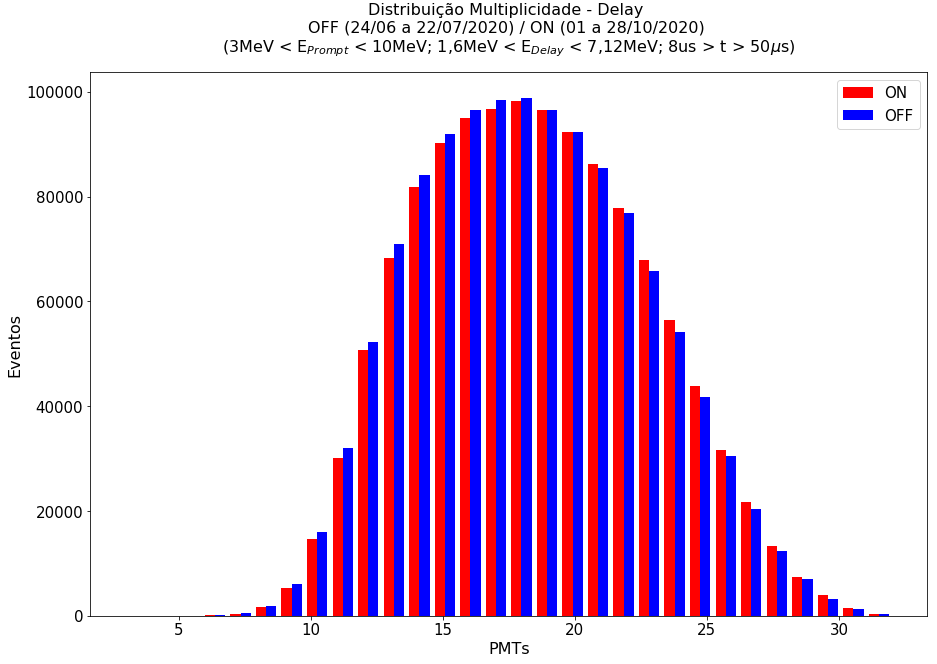

In [41]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 15})

#plt.hist(hist_MUD_ONO_all, color='red')
#plt.hist(hist_MUD_OFF_all, color='blue')
plt.hist([hist_MUD_ONO_all,hist_MUD_OFF_all] , color=['red','blue'], bins=30, label=['ON','OFF'])
plt.ylabel('Eventos', size=16)
plt.xlabel('PMTs', size=16)
plt.legend(loc="upper right")
#plt.xlim(0,500)
plt.title('Distribuição Multiplicidade - Delay \n'+
          'OFF (24/06 a 22/07/2020) / ON (01 a 28/10/2020) \n'+
        r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8us > t > 50$\mu$s)', size=16,y=1.02)
plt.savefig('histogramas/Hist_Mult_Delay_ON_OFF_crit.png')
plt.show()


## Histograma de Multiplicidade - Prompt

In [17]:
hist_MUP_ONO_all = []
hist_MUP_ONO_all.extend(h_MUP_ONO1)
hist_MUP_ONO_all.extend(h_MUP_ONO2)
hist_MUP_ONO_all.extend(h_MUP_ONO3)
hist_MUP_ONO_all.extend(h_MUP_ONO4)
hist_MUP_OFF_all = []
hist_MUP_OFF_all.extend(h_MUP_OFF1)
hist_MUP_OFF_all.extend(h_MUP_OFF2)
hist_MUP_OFF_all.extend(h_MUP_OFF3)
hist_MUP_OFF_all.extend(h_MUP_OFF4)

In [18]:
hist_PDP_ONO_all = []
hist_PDP_ONO_all.extend(h_PDP_ONO1)
hist_PDP_ONO_all.extend(h_PDP_ONO2)
hist_PDP_ONO_all.extend(h_PDP_ONO3)
hist_PDP_ONO_all.extend(h_PDP_ONO4)
hist_PDP_OFF_all = []
hist_PDP_OFF_all.extend(h_PDP_OFF1)
hist_PDP_OFF_all.extend(h_PDP_OFF2)
hist_PDP_OFF_all.extend(h_PDP_OFF3)
hist_PDP_OFF_all.extend(h_PDP_OFF4)

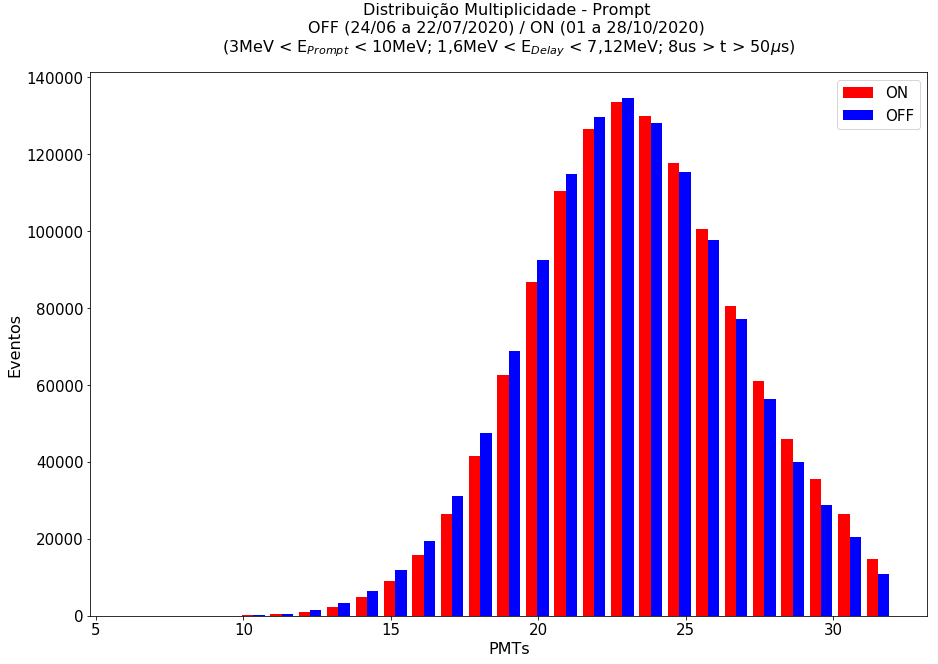

In [43]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 15})

#plt.hist(hist_MUD_ONO_all, color='red')
#plt.hist(hist_MUD_OFF_all, color='blue')
plt.hist([hist_MUP_ONO_all,hist_MUP_OFF_all] , color=['red','blue'], bins=27, label=['ON','OFF'])
plt.ylabel('Eventos', size=16)
plt.xlabel('PMTs', size=16)
plt.legend(loc="upper right")
#plt.xlim(0,500)
plt.title('Distribuição Multiplicidade - Prompt \n'+
          'OFF (24/06 a 22/07/2020) / ON (01 a 28/10/2020) \n'+
        r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8us > t > 50$\mu$s)', size=16,y=1.02)
plt.savefig('histogramas/Hist_Mult_Prompt_ON_OFF_crit.png')
plt.show()


## Mapa ON/OFF de Multiplicidade - Delay

In [100]:
rh, rw = 40, 200
t_subOFF = [[0 for x in range(rw)] for y in range(rh)]  

print('Inicio',datetime.datetime.now())
print(len(hist_MUD_OFF_all))
print(len(hist_PDD_OFF_all))

for index1 in range(len(hist_MUD_OFF_all)):
#    for index2 in range(len(h_PDD_OFF1)):
        i=int(hist_PDD_OFF_all[index1]) #delay int pe
        j=int(hist_MUD_OFF_all[index1]) #multiplicidade
        #print(j,i)
        if (i<rw)and(j<rh):
            t_subOFF[j][i]=t_subOFF[j][i]+1 
    #print(index1, index2)

#print(t_subOFF)
print('Fim',datetime.datetime.now())


Inicio 2023-11-30 07:19:00.260683
1237128
1237128
Fim 2023-11-30 07:19:05.154003


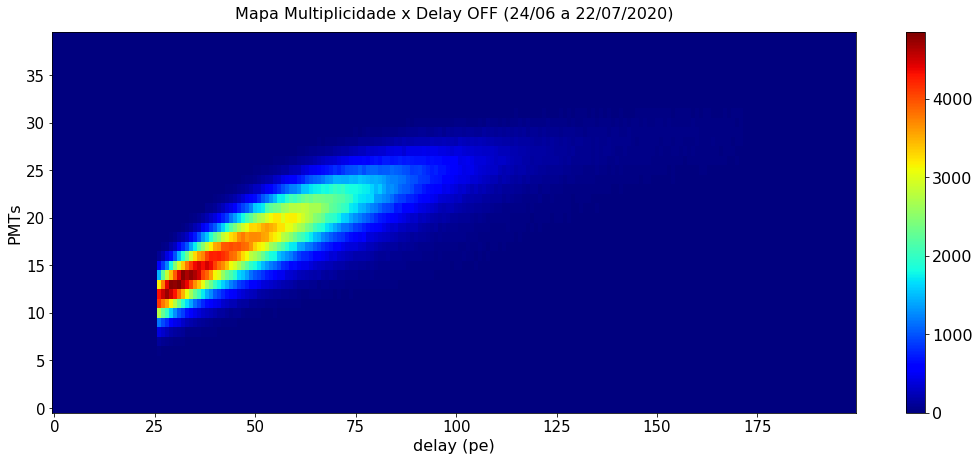

In [101]:
from matplotlib.colors import BoundaryNorm

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(np.min(t_subOFF),np.max(t_subOFF),10)
norm = BoundaryNorm(bounds, cmap.N)

fig=plt.figure(figsize=(18,7))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 16})

myplot=plt.imshow(t_subOFF,interpolation='none',norm=None,cmap=cmap,origin='lower', aspect='auto')

plt.colorbar(myplot) #, format='%.0e')

plt.xlabel('delay (pe)', size=16)
plt.ylabel('PMTs', size=16)
plt.title('Mapa Multiplicidade x Delay OFF (24/06 a 22/07/2020)', size=16,y=1.02)
plt.savefig('histogramas/Mapa_Mult_delay_OFF_crit.png')
plt.show()

In [102]:
rh, rw = 40, 200
t_subONO = [[0 for x in range(rw)] for y in range(rh)]  

print('Inicio',datetime.datetime.now())
print(len(hist_MUD_ONO_all))
print(len(hist_PDD_ONO_all))

for index1 in range(len(hist_MUD_ONO_all)):
#    for index2 in range(len(h_PDD_OFF1)):
        i=int(hist_PDD_ONO_all[index1]) #delay int pe
        j=int(hist_MUD_ONO_all[index1]) #multiplicidade
        #print(j,i)
        if (i<rw)and(j<rh):
            t_subONO[j][i]=t_subONO[j][i]+1 
    #print(index1, index2)

#print(t_subONO)
print('Fim',datetime.datetime.now())


Inicio 2023-11-30 07:19:08.064510
1234013
1234013
Fim 2023-11-30 07:19:13.222416


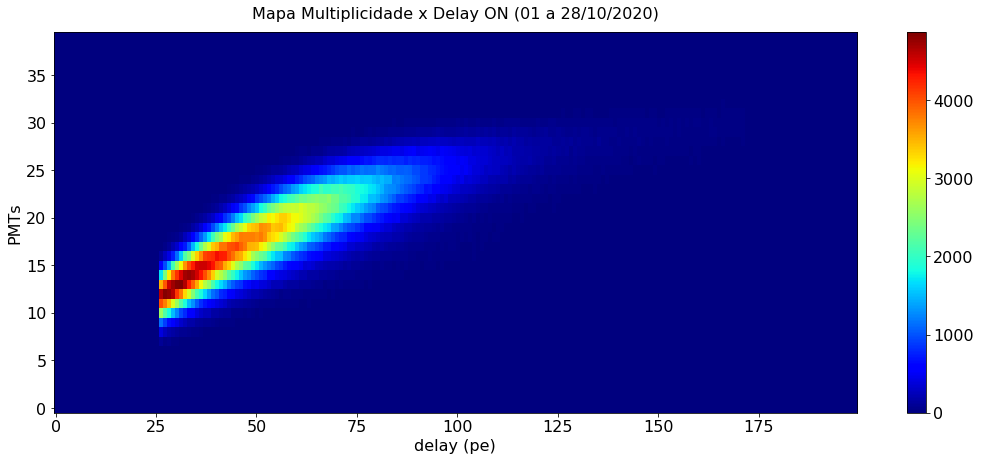

In [103]:
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(np.min(t_subONO),np.max(t_subONO),10)
norm = BoundaryNorm(bounds, cmap.N)

fig=plt.figure(figsize=(18,7))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 16})

myplot=plt.imshow(t_subONO,interpolation='none',norm=None,cmap=cmap,origin='lower', aspect='auto')

plt.colorbar(myplot) #, format='%.0e')

plt.xlabel('delay (pe)', size=16)
plt.ylabel('PMTs', size=16)
plt.title('Mapa Multiplicidade x Delay ON (01 a 28/10/2020)', size=16,y=1.02)
plt.savefig('histogramas/Mapa_Mult_delay_ON_crit.png')
plt.show()

In [104]:
print('Inicio',datetime.datetime.now())

t_subONOFF = [[(t_subONO[y][x] - t_subOFF[y][x]) for x in range(rw)] for y in range(rh)]  

print(t_subONOFF[11])

print('Fim',datetime.datetime.now())

Inicio 2023-11-30 07:19:28.407108
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -92, -28, -114, -165, -132, -146, -60, -151, -105, -79, -120, -88, -61, -56, -43, -76, -20, -58, -61, -75, -11, -19, -28, -1, -5, -23, -20, -2, 0, -21, -6, -6, -3, -7, -2, -13, 0, 4, 0, -2, 2, -5, 1, -2, 0, -3, -7, -3, 0, -2, 2, -1, 0, -1, 2, 1, -3, -2, -4, -1, -1, 1, 2, -1, 2, 3, 1, 0, -1, 0, 0, -1, 0, -1, 1, -1, 0, 0, -3, -1, 0, -1, 1, 0, 0, 0, 0, -2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fim 2023-11-30 07:19:28.413607


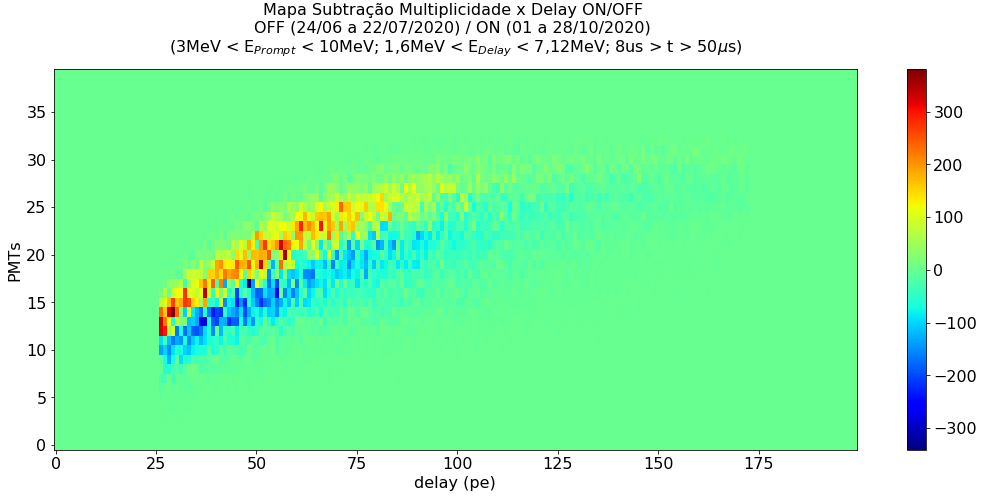

In [105]:
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(np.min(t_subONOFF),np.max(t_subONOFF),10)
norm = BoundaryNorm(bounds, cmap.N)

fig=plt.figure(figsize=(18,7))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 16})

myplot=plt.imshow(t_subONOFF,interpolation='none',norm=None,cmap=cmap,origin='lower', aspect='auto')

plt.colorbar(myplot) #, format='%.0e')

plt.xlabel('delay (pe)', size=16)
plt.ylabel('PMTs', size=16)
plt.title('Mapa Subtração Multiplicidade x Delay ON/OFF \n'+
          'OFF (24/06 a 22/07/2020) / ON (01 a 28/10/2020) \n'+
        r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8us > t > 50$\mu$s)', size=16,y=1.02)
plt.savefig('histogramas/Mapa_Mult_delay_Sub_ONOFF_crit.png')
plt.show()

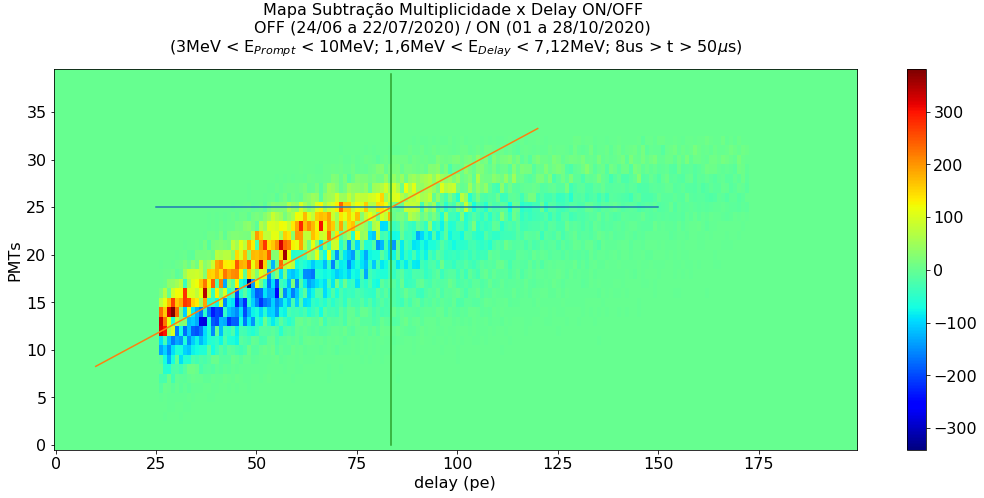

In [107]:
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(np.min(t_subONOFF),np.max(t_subONOFF),10)
norm = BoundaryNorm(bounds, cmap.N)

fig=plt.figure(figsize=(18,7))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 16})

myplot=plt.imshow(t_subONOFF,interpolation='none',norm=None,cmap=cmap,origin='lower', aspect='auto')

fit1_x = np.linspace(25, 150, num=125)
fit1_y = [25 for x in range(len(fit1_x))]
plt.plot(fit1_x, fit1_y)

fit2_x = np.linspace(10, 120, num=110)
fit2_y = [(x/4.4 + 6) for x in fit2_x]
plt.plot(fit2_x, fit2_y)

fit3_y = np.linspace(0, 39, num=40)
fit3_x = [83.6 for x in range(len(fit3_y))]
plt.plot(fit3_x, fit3_y)

plt.colorbar(myplot) #, format='%.0e')

plt.xlabel('delay (pe)', size=16)
plt.ylabel('PMTs', size=16)
plt.title('Mapa Subtração Multiplicidade x Delay ON/OFF \n'+
          'OFF (24/06 a 22/07/2020) / ON (01 a 28/10/2020) \n'+
        r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8us > t > 50$\mu$s)', size=16,y=1.02)
plt.savefig('histogramas/Mapa_Mult_delay_Sub_ONOFF_crit_fit.png')
plt.show()

## Histograma mapa ON/OFF

In [115]:
print('Inicio',datetime.datetime.now())

t_hist_ONOFF = [sum(t_subONOFF[y]) for y in range(rh)] 
x_hist_ONOFF = [x+1 for x in range(rh)]

print(x_hist_ONOFF)
print(t_hist_ONOFF)

print('Fim',datetime.datetime.now())

Inicio 2023-11-30 07:28:38.503909
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
[0, 0, 0, -2, -1, -15, -43, -78, -280, -650, -1419, -1922, -1418, -2636, -2292, -1689, -1587, -1681, -613, 35, 44, 674, 903, 2222, 2243, 2053, 1150, 1324, 999, 519, 722, 222, 101, 0, 0, 0, 0, 0, 0, 0]
Fim 2023-11-30 07:28:38.505937


No handles with labels found to put in legend.


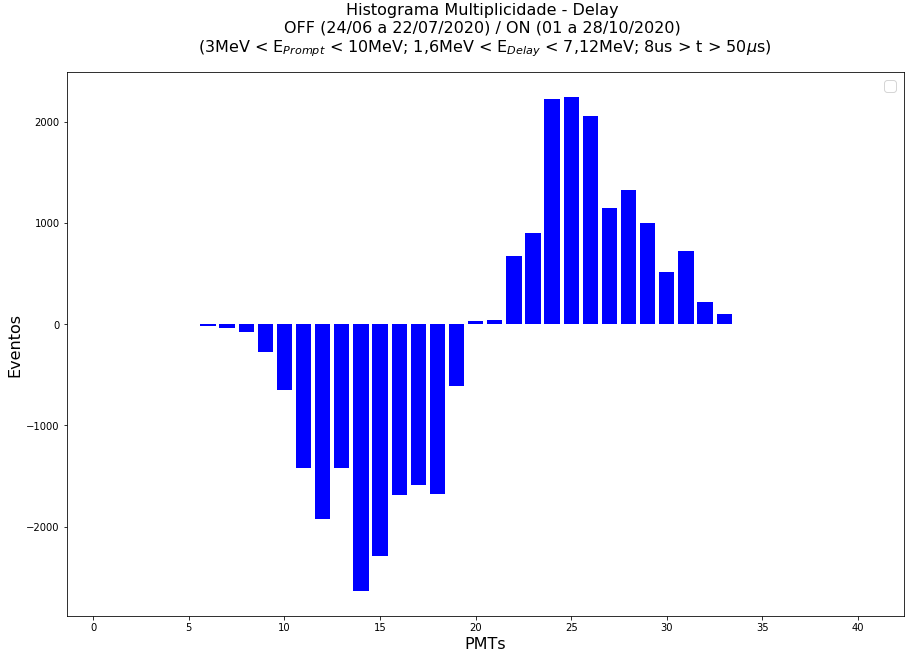

In [140]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 15})

#plt.hist(hist_MUD_ONO_all, color='red')
plt.bar(x_hist_ONOFF, t_hist_ONOFF, color='blue')
#plt.hist([hist_MUP_ONO_all,hist_MUP_OFF_all] , color=['red','blue'], bins=27, label=['ON','OFF'])
plt.ylabel('Eventos', size=16)
plt.xlabel('PMTs', size=16)
plt.legend(loc="upper right")
#plt.xlim(0,500)
plt.title('Histograma Multiplicidade - Delay \n'+
          'OFF (24/06 a 22/07/2020) / ON (01 a 28/10/2020) \n'+
        r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8us > t > 50$\mu$s)', size=16,y=1.02)
plt.savefig('histogramas/Hist_Mult_Delay_subONOFF_crit.png')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
# if using a Jupyter notebook, include:
%matplotlib inline

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111, projection='3d')


x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)
X,Y = np.meshgrid(x,y)
Z = X*np.exp(-X2 - Y2)


mycmap = plt.get_cmap('gist_earth')
ax1.set_title('gist_earth color map')
surf1 = ax1.plot_surface(X, Y, Z, cmap=mycmap)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)


plt.show()

In [132]:
print(X[1][2])
print(np.array([[1, 2], [3, 4]]))

2
[[1 2]
 [3 4]]


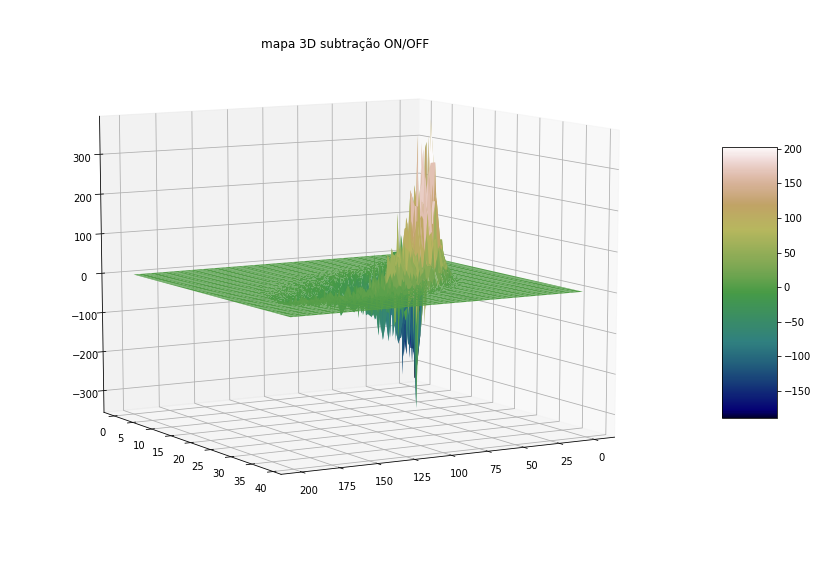

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
# if using a Jupyter notebook, include:
%matplotlib inline


fig=plt.figure(figsize=(15,10))
#ax = fig.add_subplot(1, 1, 1)

#plt.rcParams.update({'font.size': 15})

#fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111, projection='3d')


x = np.arange(0, rw, 1)
y = np.arange(0, rh, 1)
X,Y = np.meshgrid(x,y)
Zy = []
Z = []
for ix in range(rh):
    Zx = []
    for iy in range(rw):
        Zx.append(t_subONOFF[ix][iy])
    Zy.append(Zx)
Z = np.array(Zy)
    
mycmap = plt.get_cmap('gist_earth')
ax1.set_title('mapa 3D subtração ON/OFF')
#ax1.view_init(30, 90)
ax1.view_init(10, 60)  #param 1: giro vertical; param 2: giro horizontal

surf1 = ax1.plot_surface(X, Y, Z, cmap=mycmap)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

plt.savefig('histogramas/Mapa3D_Mult_delay_Sub_ONOFF_crit.png')
plt.show()

## Mapa ON/OFF de Multiplicidade - Prompt

In [117]:
rh, rw = 40, 200
t_subP_OFF = [[0 for x in range(rw)] for y in range(rh)]  

print('Inicio',datetime.datetime.now())
print(len(hist_MUP_OFF_all))
print(len(hist_PDP_OFF_all))

for index1 in range(len(hist_MUP_OFF_all)):
        i=int(hist_PDP_OFF_all[index1]) #prompt int pe
        j=int(hist_MUP_OFF_all[index1]) #multiplicidade
        #print(j,i)
        if (i<rw)and(j<rh):
            t_subP_OFF[j][i]=t_subP_OFF[j][i]+1 
    #print(index1, index2)

print('Fim',datetime.datetime.now())

Inicio 2023-11-30 07:30:35.839721
1237128
1237128
Fim 2023-11-30 07:30:40.321435


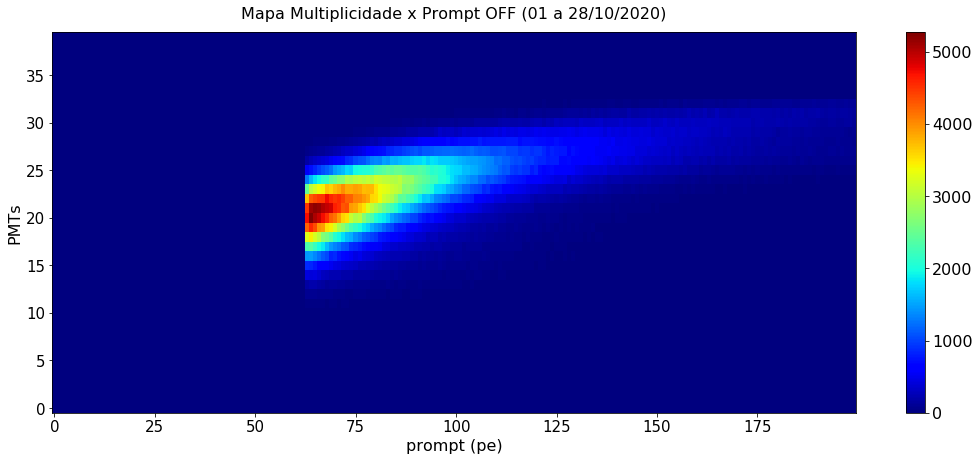

In [118]:
from matplotlib.colors import BoundaryNorm

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(np.min(t_subP_OFF),np.max(t_subP_OFF),10)
norm = BoundaryNorm(bounds, cmap.N)

fig=plt.figure(figsize=(18,7))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 16})

myplot=plt.imshow(t_subP_OFF,interpolation='none',norm=None,cmap=cmap,origin='lower', aspect='auto')

plt.colorbar(myplot) #, format='%.0e')

plt.xlabel('prompt (pe)', size=16)
plt.ylabel('PMTs', size=16)
plt.title('Mapa Multiplicidade x Prompt OFF (01 a 28/10/2020)', size=16,y=1.02)
#plt.savefig('histogramas/Mapa-delay-prompt-OFF-chi20200629.png')
plt.show()

In [119]:
rh, rw = 40, 200
t_subP_ONO = [[0 for x in range(rw)] for y in range(rh)]  

print('Inicio',datetime.datetime.now())
print(len(hist_MUP_ONO_all))
print(len(hist_PDP_ONO_all))

for index1 in range(len(hist_MUP_ONO_all)):
        i=int(hist_PDP_ONO_all[index1]) #prompt int pe
        j=int(hist_MUP_ONO_all[index1]) #multiplicidade
        #print(j,i)
        if (i<rw)and(j<rh):
            t_subP_ONO[j][i]=t_subP_ONO[j][i]+1 
    #print(index1, index2)

print('Fim',datetime.datetime.now())

Inicio 2023-11-30 07:30:41.604334
1234013
1234013
Fim 2023-11-30 07:30:46.129846


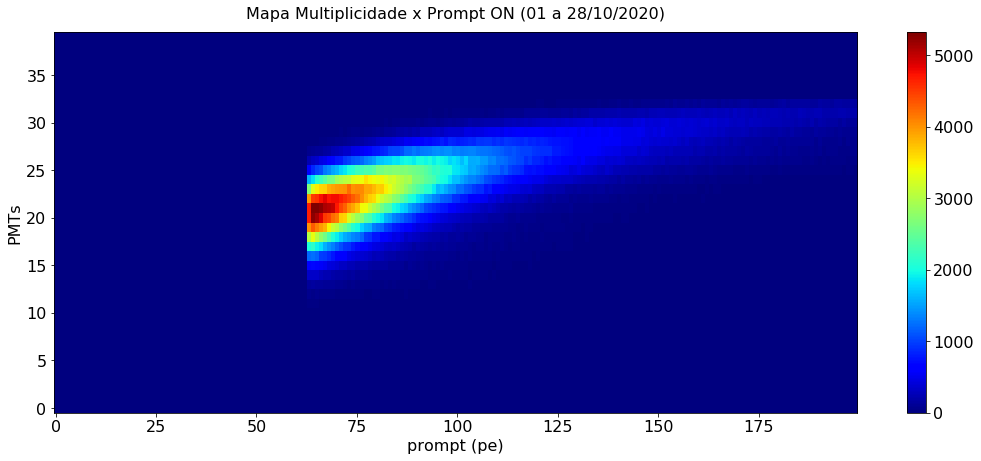

In [120]:
from matplotlib.colors import BoundaryNorm

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(np.min(t_subP_ONO),np.max(t_subP_ONO),10)
norm = BoundaryNorm(bounds, cmap.N)

fig=plt.figure(figsize=(18,7))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 16})

myplot=plt.imshow(t_subP_ONO,interpolation='none',norm=None,cmap=cmap,origin='lower', aspect='auto')

plt.colorbar(myplot) #, format='%.0e')

plt.xlabel('prompt (pe)', size=16)
plt.ylabel('PMTs', size=16)
plt.title('Mapa Multiplicidade x Prompt ON (01 a 28/10/2020)', size=16,y=1.02)
#plt.savefig('histogramas/Mapa-delay-prompt-OFF-chi20200629.png')
plt.show()

In [121]:
print('Inicio',datetime.datetime.now())

t_subP_ONOFF = [[(t_subP_ONO[y][x] - t_subP_OFF[y][x]) for x in range(rw)] for y in range(rh)]  

print(t_subP_ONOFF[11])

print('Fim',datetime.datetime.now())

Inicio 2023-11-30 07:30:48.634700
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -17, -11, -1, -10, -12, -1, -17, -13, 3, -9, -13, -4, -7, -6, -2, -1, 7, -4, 3, -11, -4, -5, -3, -1, 1, 0, 4, 0, -5, -5, 1, -5, -1, 1, -3, -1, -2, -2, 3, 0, 0, -2, -3, -5, -1, 2, -5, -2, -1, 1, -2, 0, 0, -1, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fim 2023-11-30 07:30:48.639701


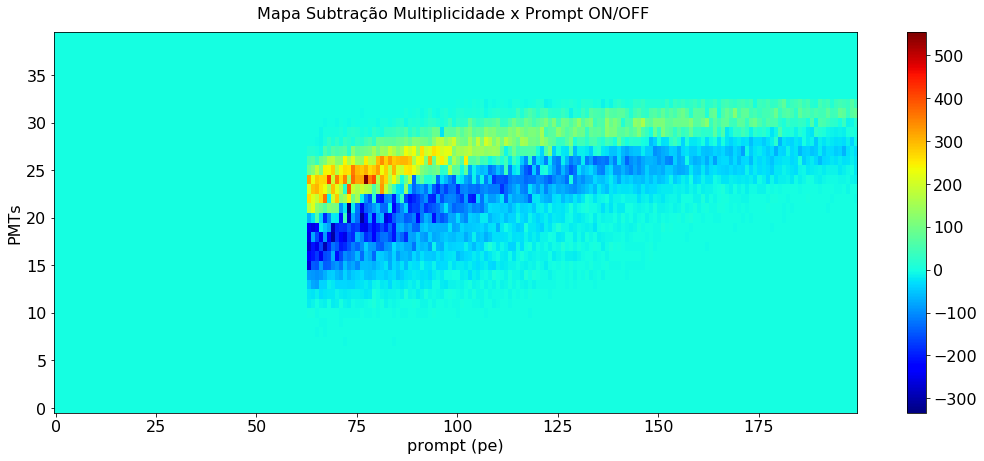

In [122]:
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(np.min(t_subP_ONOFF),np.max(t_subP_ONOFF),10)
norm = BoundaryNorm(bounds, cmap.N)

fig=plt.figure(figsize=(18,7))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 16})

myplot=plt.imshow(t_subP_ONOFF,interpolation='none',norm=None,cmap=cmap,origin='lower', aspect='auto')

plt.colorbar(myplot) #, format='%.0e')

plt.xlabel('prompt (pe)', size=16)
plt.ylabel('PMTs', size=16)
plt.title('Mapa Subtração Multiplicidade x Prompt ON/OFF ', size=16,y=1.02)
#plt.savefig('histogramas/Mapa-delay-prompt-OFF-chi20200629.png')
plt.show()

## Função genérica de mapa de subtração

In [159]:
def fnc_subONOFF(pl_MUD_ON, pl_PDD_ON, pl_MUD_OFF, pl_PDD_OFF):
    rh, rw = 40, 200

    vt_subON = [[0 for x in range(rw)] for y in range(rh)]  
    vt_subOFF = [[0 for x in range(rw)] for y in range(rh)]  

    for index1 in range(len(pl_MUD_ON)):
        i=int(pl_PDD_ON[index1]) #delay int pe
        j=int(pl_MUD_ON[index1]) #multiplicidade
        #print(j,i)
        if (i<rw)and(j<rh):
            vt_subON[j][i]=vt_subON[j][i]+1 

    for index1 in range(len(pl_MUD_OFF)):
        i=int(pl_PDD_OFF[index1]) #delay int pe
        j=int(pl_MUD_OFF[index1]) #multiplicidade
        #print(j,i)
        if (i<rw)and(j<rh):
            vt_subOFF[j][i]=vt_subOFF[j][i]+1 
                  
    return([[(vt_subON[y][x] - vt_subOFF[y][x]) for x in range(rw)] for y in range(rh)])
                  

def plot_mapa_sub(pl_MUD_ON, pl_PDD_ON, pl_MUD_OFF, pl_PDD_OFF, ps_subTitle, ps_subTitle2, ps_subFile):
    print('Inicio',datetime.datetime.now())
    
    vt_subONOFF = fnc_subONOFF(pl_MUD_ON, pl_PDD_ON, pl_MUD_OFF, pl_PDD_OFF)

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(np.min(vt_subONOFF),np.max(vt_subONOFF),10)
    norm = BoundaryNorm(bounds, cmap.N)

    fig=plt.figure(figsize=(18,7))
    ax = fig.add_subplot(1, 1, 1)

    plt.rcParams.update({'font.size': 16})

    myplot=plt.imshow(vt_subONOFF,interpolation='none',norm=None,cmap=cmap,origin='lower', aspect='auto')

    plt.colorbar(myplot) #, format='%.0e')

    plt.xlabel('delay (pe)', size=16)
    plt.ylabel('PMTs', size=16)
    plt.title('Mapa Subtração Multiplicidade x Delay '+ps_subTitle+' \n'+
              ps_subTitle2+' \n'+
             r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8us > t > 50$\mu$s)', size=16,y=1.02)
    plt.savefig('histogramas/Mapa_Mult_delay_'+ps_subFile+'.png')
    plt.show()

    print('Fim',datetime.datetime.now())

In [160]:
def plot_bar_mud(pl_MUD_ON, pl_PDD_ON, pl_MUD_OFF, pl_PDD_OFF, ps_subTitle, ps_subTitle2, ps_subFile):
    
    vt_subONOFF = fnc_subONOFF(pl_MUD_ON, pl_PDD_ON, pl_MUD_OFF, pl_PDD_OFF)

    vt_hist_ONOFF = [sum(vt_subONOFF[y]) for y in range(rh)] 
    vx_hist_ONOFF = [x+1 for x in range(rh)]
    
    fig=plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1, 1, 1)

    plt.rcParams.update({'font.size': 15})

    plt.bar(vx_hist_ONOFF, vt_hist_ONOFF, color='blue')

    plt.ylabel('Eventos', size=16)
    plt.xlabel('PMTs', size=16)
    plt.legend(loc="upper right")

    plt.title('Histograma Multiplicidade - Delay '+ps_subTitle+'\n'+
              ps_subTitle2+' \n'+
             r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8us > t > 50$\mu$s)', size=16,y=1.02)
    plt.savefig('histogramas/Hist_Mult_Delay_'+ps_subFile+'_crit.png')
    plt.show()

In [165]:
def plot_hist_zmud(pl_MUD_ON, pl_PDD_ON, pl_MUD_OFF, pl_PDD_OFF, ps_subTitle, ps_subTitle2, ps_subFile):
    
    vt_subONOFF = fnc_subONOFF(pl_MUD_ON, pl_PDD_ON, pl_MUD_OFF, pl_PDD_OFF)
    
    hist_subD = []

    hvt_subONOFF = fnc_subONOFF(pl_MUD_ON, pl_PDD_ON, pl_MUD_OFF, pl_PDD_OFF)

    for indi in range(rh):
        for indj in range(rw):
            if (hvt_subONOFF[indi][indj]!=0):
                hist_subD.append(hvt_subONOFF[indi][indj])
            
            
    fig=plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1, 1, 1)

    plt.rcParams.update({'font.size': 15})

    plt.hist(hist_subD, bins=60)
    plt.ylabel('Eventos', size=16)
    plt.xlabel('qtde mult', size=16)
    plt.legend(loc="upper right")

    plt.title('Distribuição Multiplicidade - Delay '+ps_subTitle+'\n'+
               ps_subTitle2+' \n'+
            r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8us > t > 50$\mu$s)', size=16,y=1.02)
    plt.savefig('histogramas/Hist_zMult_Delay_'+ps_subFile+'_crit.png')
    plt.show()


## Execuções / plots

## ON1 x OFF4

Inicio 2023-12-04 07:34:06.233194


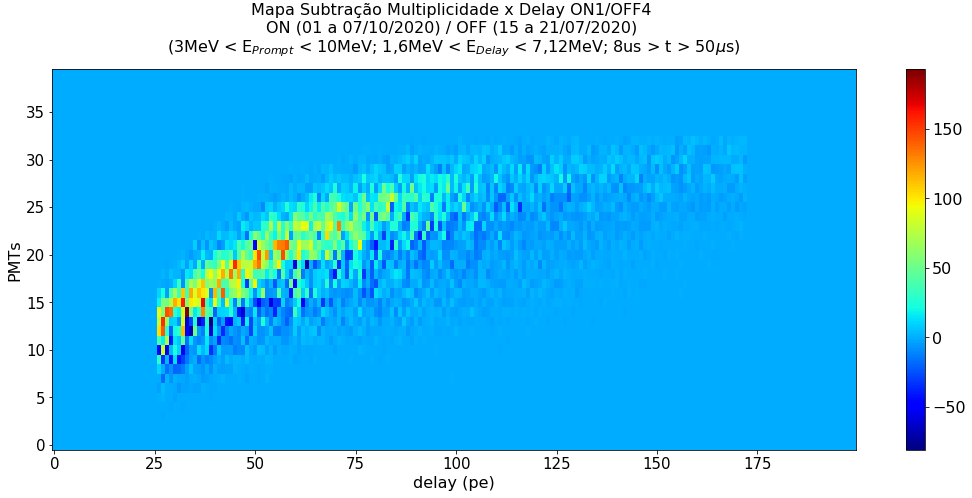

Fim 2023-12-04 07:34:09.872710


No handles with labels found to put in legend.


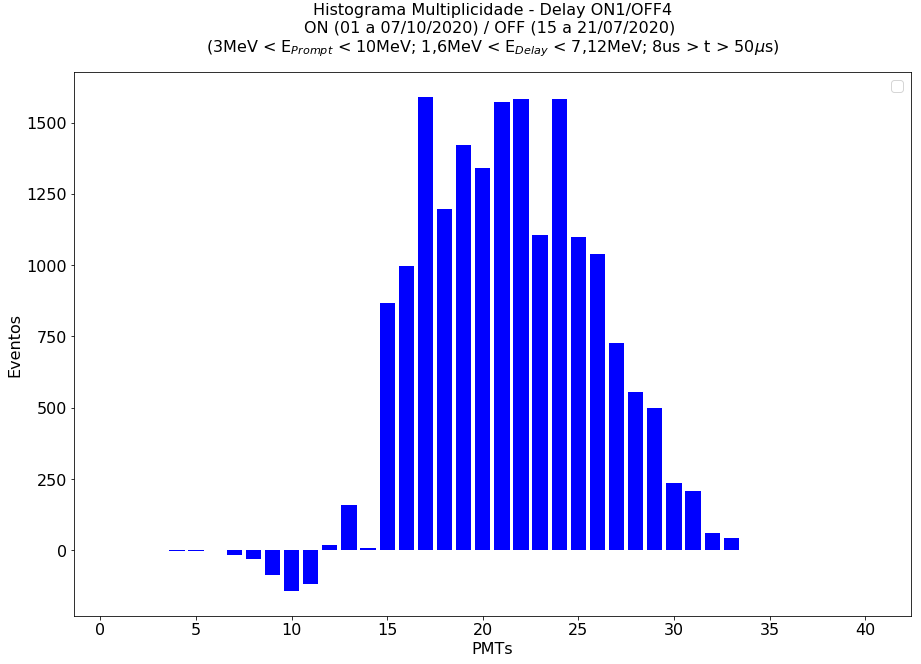

In [168]:
#hist_MUD_ONO_all = []
#hist_MUD_ONO_all.extend(h_MUD_ONO1)
#hist_MUD_ONO_all.extend(h_MUD_ONO2)

plot_mapa_sub (h_MUD_ONO1, h_PDD_ONO1, h_MUD_OFF4, h_PDD_OFF4,'ON1/OFF4', 'ON (01 a 07/10/2020) / OFF (15 a 21/07/2020)', 'ON1_OFF4')
plot_bar_mud (h_MUD_ONO1, h_PDD_ONO1, h_MUD_OFF4, h_PDD_OFF4,'ON1/OFF4', 'ON (01 a 07/10/2020) / OFF (15 a 21/07/2020)', 'ON1_OFF4')


No handles with labels found to put in legend.


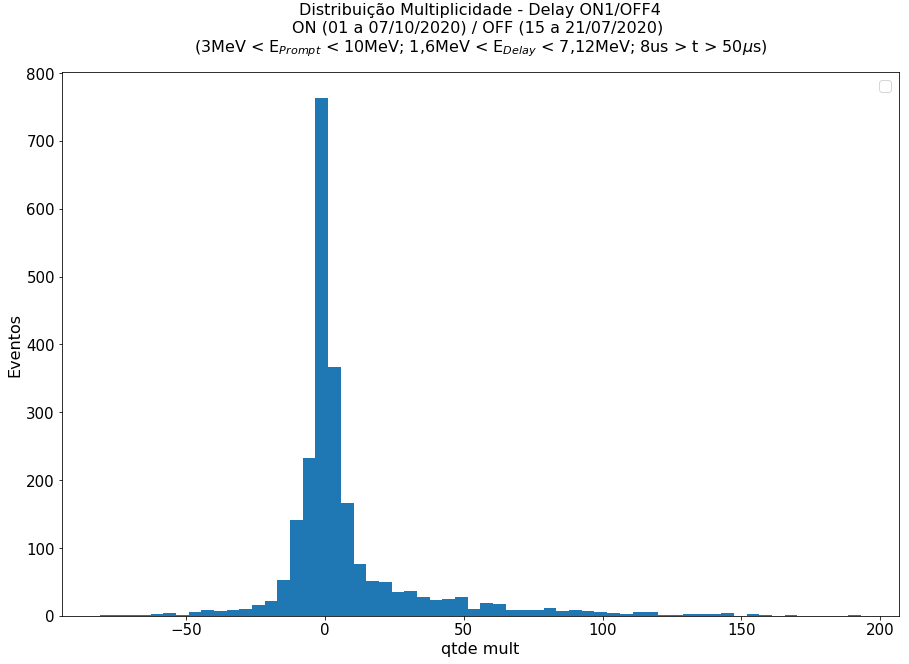

In [169]:
plot_hist_zmud (h_MUD_ONO1, h_PDD_ONO1, h_MUD_OFF4, h_PDD_OFF4,'ON1/OFF4', 'ON (01 a 07/10/2020) / OFF (15 a 21/07/2020)', 'ON1_OFF4')


## OFF1 x OFF4

Inicio 2023-12-04 07:34:27.064108


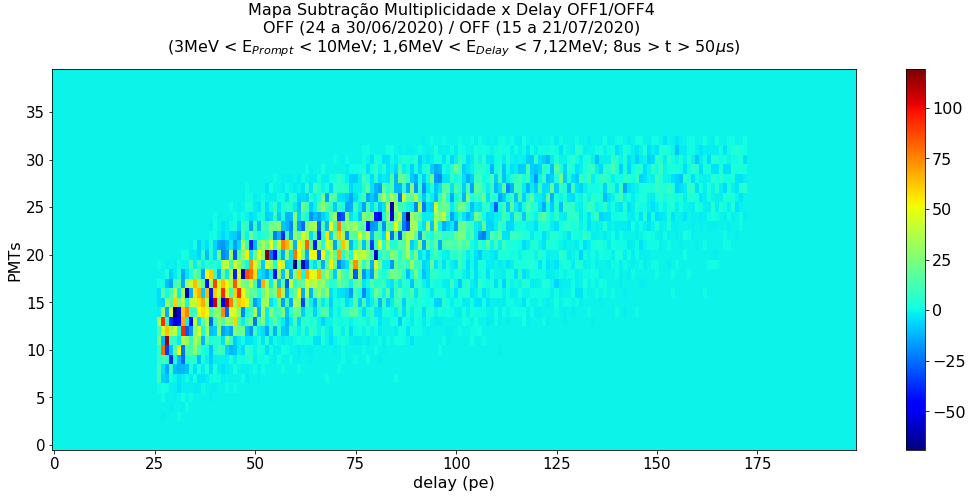

Fim 2023-12-04 07:34:30.490589


No handles with labels found to put in legend.


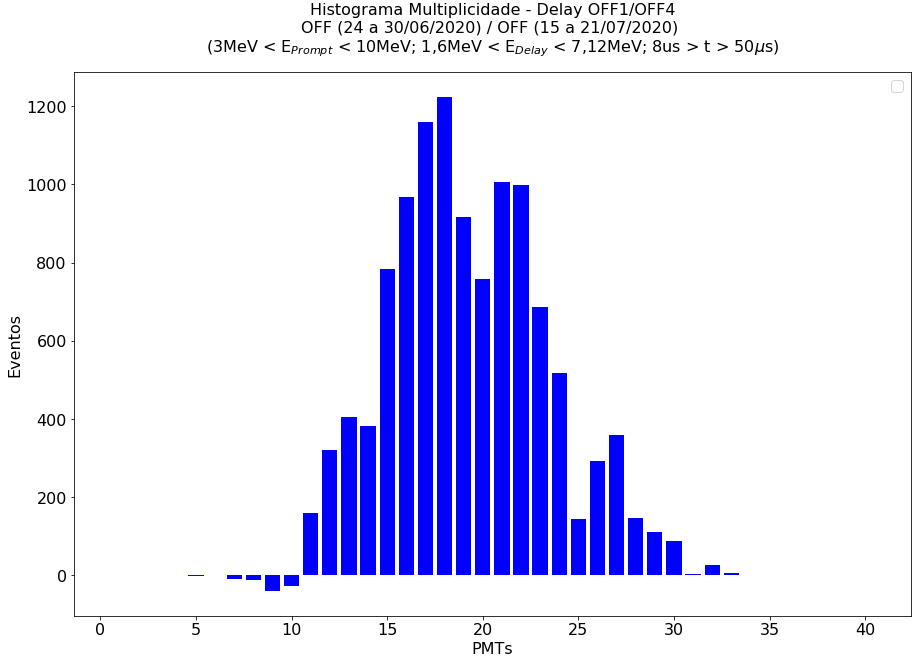

In [170]:
plot_mapa_sub (h_MUD_OFF1, h_PDD_OFF1, h_MUD_OFF4, h_PDD_OFF4,'OFF1/OFF4', 'OFF (24 a 30/06/2020) / OFF (15 a 21/07/2020)', 'OFF1_OFF4')
plot_bar_mud (h_MUD_OFF1, h_PDD_OFF1, h_MUD_OFF4, h_PDD_OFF4,'OFF1/OFF4', 'OFF (24 a 30/06/2020) / OFF (15 a 21/07/2020)', 'OFF1_OFF4')


No handles with labels found to put in legend.


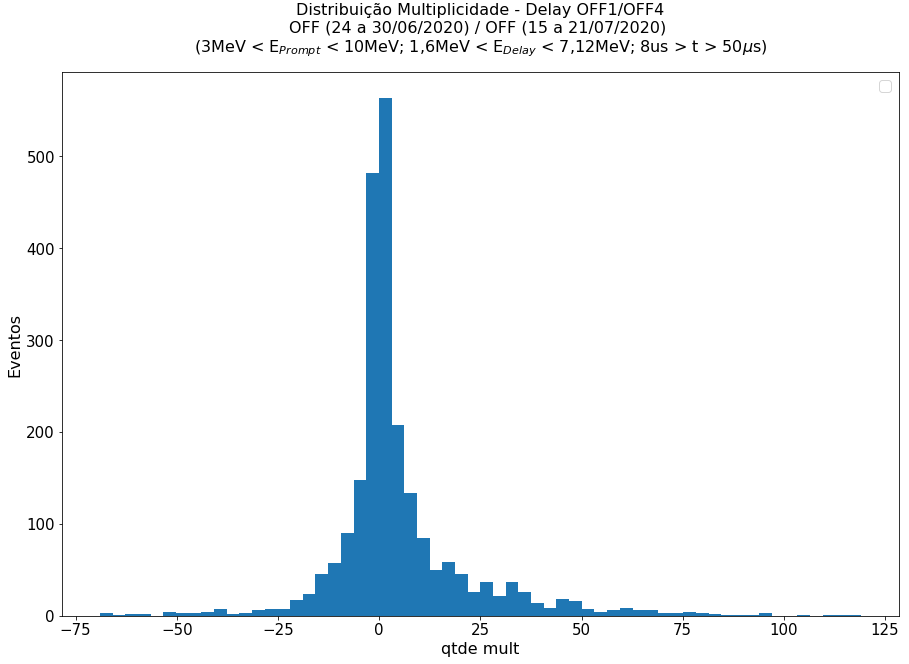

In [171]:
plot_hist_zmud (h_MUD_OFF1, h_PDD_OFF1, h_MUD_OFF4, h_PDD_OFF4,'OFF1/OFF4', 'OFF (24 a 30/06/2020) / OFF (15 a 21/07/2020)', 'OFF1_OFF4')


## ON1 / ON2

Inicio 2023-12-04 08:25:32.696354


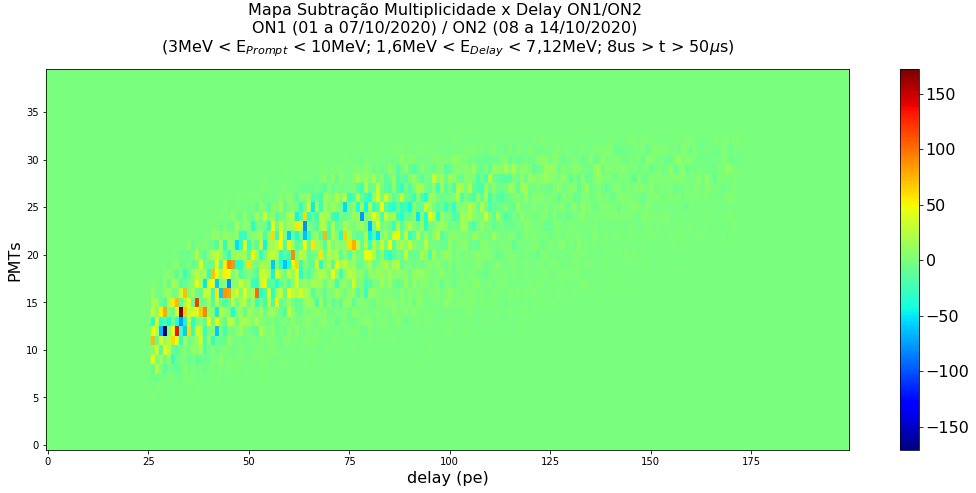

Fim 2023-12-04 08:25:36.868514


No handles with labels found to put in legend.


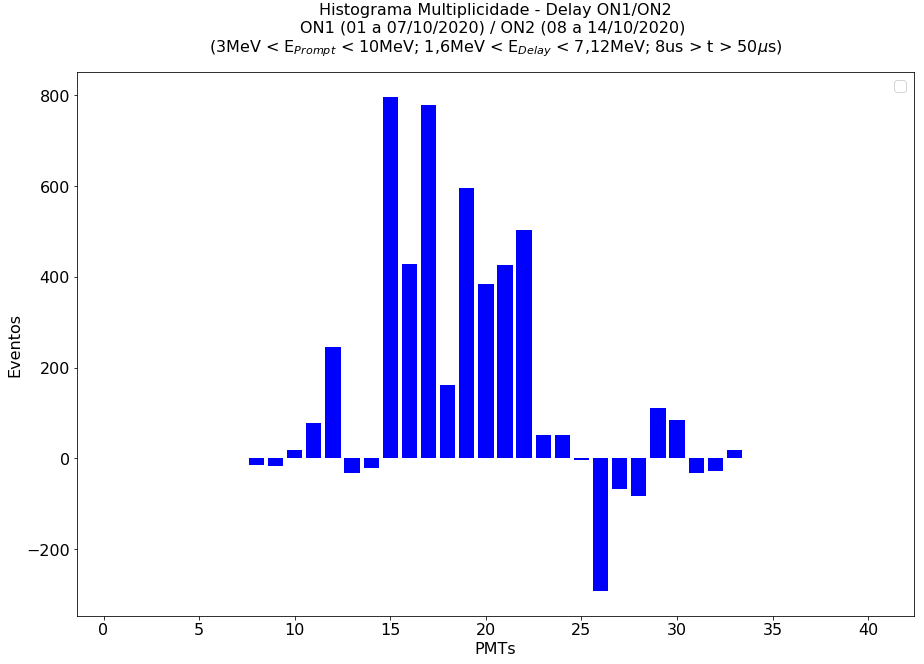

In [180]:
plot_mapa_sub (h_MUD_ONO1, h_PDD_ONO1, h_MUD_ONO2, h_PDD_ONO2,'ON1/ON2', 'ON1 (01 a 07/10/2020) / ON2 (08 a 14/10/2020)', 'ON1_ON2')
plot_bar_mud (h_MUD_ONO1, h_PDD_ONO1, h_MUD_ONO2, h_PDD_ONO2,'ON1/ON2', 'ON1 (01 a 07/10/2020) / ON2 (08 a 14/10/2020)', 'ON1_ON2')


No handles with labels found to put in legend.


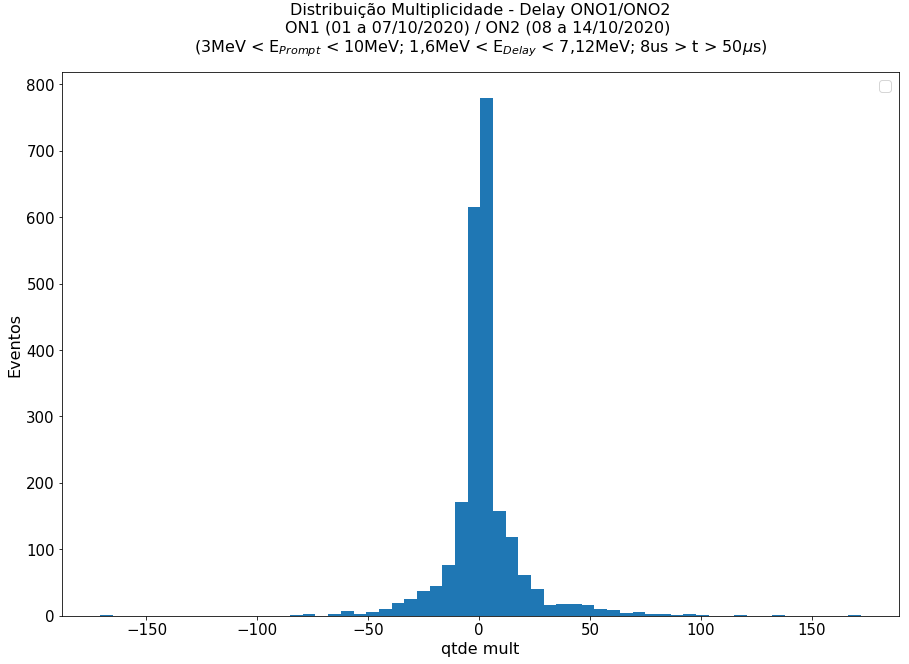

In [181]:
plot_hist_zmud (h_MUD_ONO1, h_PDD_ONO1, h_MUD_ONO2, h_PDD_ONO2,'ONO1/ONO2', 'ON1 (01 a 07/10/2020) / ON2 (08 a 14/10/2020)', 'ONO1_ONO2')


## ON1 / ONO4

In [182]:
plot_mapa_sub (h_MUD_ON1, h_PDD_ON1, h_MUD_ONO4, h_PDD_ONO4,'ON1/ONO4', 'ON1 (24 a 30/08/2020) / ONO4 (22 a 28/10/2020)', 'ON1_ONO4')
plot_bar_mud (h_MUD_ON1, h_PDD_ON1, h_MUD_ONO4, h_PDD_ONO4,'ON1/ONO4', 'ON1 (24 a 30/08/2020) / ONO4 (22 a 28/10/2020)', 'ON1_ONO4')


NameError: name 'h_MUD_ON1' is not defined

## Histogramas

In [148]:
hist_subD = []

hgt_subONOFF = fnc_subONOFF(pl_MUD_ON, pl_PDD_ON, pl_MUD_OFF, pl_PDD_OFF)

for indi in range(rh):
    for indj in range(rw):
        if (hgt_subONOFF[indi][indj]!=0):
            hist_subD.append(hgt_subONOFF[indi][indj])

No handles with labels found to put in legend.


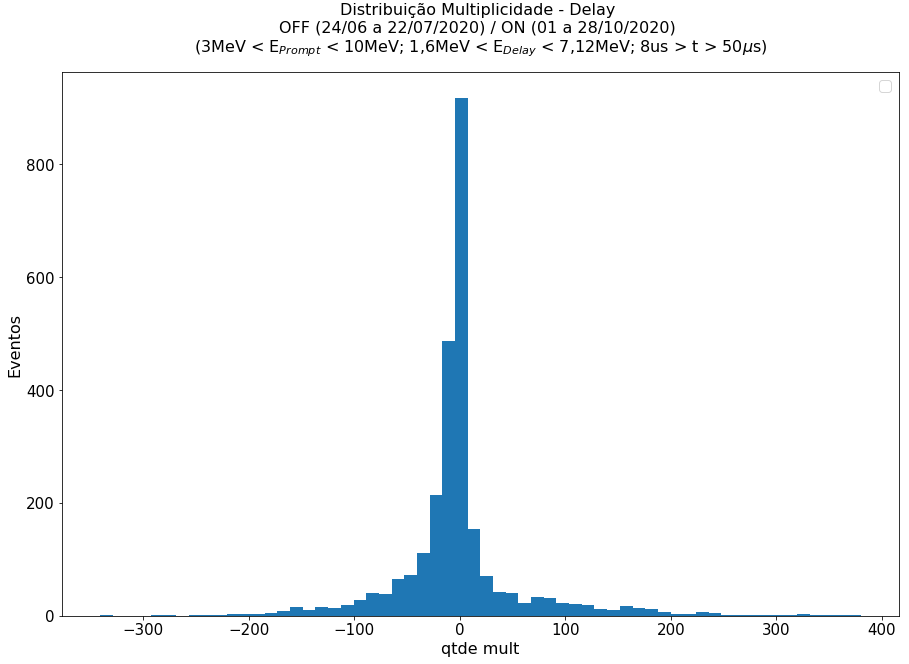

In [151]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 15})

#plt.hist(hist_MUD_ONO_all, color='red')
#plt.hist(hist_MUD_OFF_all, color='blue')
plt.hist(hist_subD, bins=60)
plt.ylabel('Eventos', size=16)
plt.xlabel('qtde mult', size=16)
plt.legend(loc="upper right")

plt.title('Distribuição Multiplicidade - Delay \n'+
          'OFF (24/06 a 22/07/2020) / ON (01 a 28/10/2020) \n'+
        r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8us > t > 50$\mu$s)', size=16,y=1.02)
#plt.savefig('histogramas/Hist_Mult_Delay_ON_OFF_crit.png')
plt.show()